# **---------------------------- Import Statments --------------------------------**

In [ ]:
!pip install skfeature-chappers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 9.0 MB/s eta 0:00:00


In [ ]:
# ======================================================
# Basic Libraries
# ======================================================
import numpy as np
import pandas as pd
import math

# ======================================================
# Visualization
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# ======================================================
# Signal Processing
# ======================================================
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import zscore, median_abs_deviation

# ======================================================
# Feature Selection
# ======================================================
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import (
    SelectKBest,
    SelectFromModel,
    mutual_info_classif
)
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SequentialFeatureSelector


# ======================================================
# Preprocessing
# ======================================================
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    label_binarize
)
from sklearn.impute import SimpleImputer

# ======================================================
# Handling Imbalanced Data
# ======================================================
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# ======================================================
# Modeling
# ======================================================
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score
)

# ======================================================
# Evaluation Metrics
# ======================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)

# ======================================================
# Dimensionality Reduction
# ======================================================
from sklearn.decomposition import PCA

from itertools import product

'''
import warnings
warnings.filterwarnings('ignore')     # ignore warnings to keep output clean
'''


"\nimport warnings\nwarnings.filterwarnings('ignore')     # ignore warnings to keep output clean\n"

# **----------------------------- Load Data ---------------------------------------**

In [ ]:
EMG_df = pd.read_excel(
    "/content/EMG Data NAAFH 3Ver3.xlsx",
    keep_default_na=True,
    na_values=['NA', 'N/A', '']   # Only these become NaN
)

# Keep "None" as text (not missing)
cols = ['comorbidities', 'medications', 'surgery_history','injury_type']

for c in cols:
    EMG_df[c] = EMG_df[c].fillna("None")

# Preview
EMG_df.head()



ID  age sex   BMI dominant_side affected_limb limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                 37   
1   2   41   F  33.7         Right    Left Wrist               35.8   
2   3   24   M  37.1         Right   Right Wrist               35.7   
3   4   52   M  26.4         Right   Right Wrist                 36   
4   5   47   M  25.9         Right   Right Wrist               35.7   

  affected_limb_dominance                injury_type time_since_injury_months  \
0            Non-dominant  Compression – Neuropraxia                        1   
1            Non-dominant    Traumatic – Neuropraxia                        5   
2                Dominant   Entrapment – Neurotmesis                       10   
3                Dominant  Compression – Neuropraxia                        6   
4                Dominant    Traumatic – Axonotmesis                       10   

   ... Insertional_Activity Positive_Sharp_Waves  Fibrillation Fasciculation  \
0  ...            Increased         Present (2+)  Present (1+)  Present (1+)   
1  ...     Mildly increased         Present (1+)  Present (1+)        Absent   
2  ...            Increased         Present (2+)  Present (1+)  Present (1+)   
3  ...            Increased         Present (1+)  Present (1+)  Present (1+)   
4  ...            Increased         Present (1+)  Present (3+)  Present (2+)   

  MUAP_Amplitude (mV) MUAP_Duration (ms) Recruitment_Pattern Polyphasic_Units  \
0                 3.3                9.1             Reduced               43   
1                 5.2                9.2             Reduced               23   
2                 1.9               14.2    Severely reduced               61   
3                 3.7               10.9             Reduced               41   
4                 1.5                9.0    Severely reduced               35   

  Voluntary_Activation_Quality Severity_Label  
0                      Partial       Moderate  
1                       Normal           Mild  
2                      Minimal         Severe  
3                      Partial       Moderate  
4                      Minimal         Severe  

[5 rows x 29 columns]

# **------------------------------------ EDA --------------------------------------**

## Data Structure Understanding

In [ ]:
print("Shape of the dataset:", EMG_df.shape)

Shape of the dataset: (238, 29)


In [ ]:
print("Columns:", EMG_df.columns)

Columns: Index(['ID', 'age', 'sex', 'BMI', 'dominant_side', 'affected_limb',
       'limb_temperature_c', 'affected_limb_dominance', 'injury_type',
       'time_since_injury_months', 'comorbidities', 'medications',
       'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type',
       'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity',
       'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation',
       'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern',
       'Polyphasic_Units', 'Voluntary_Activation_Quality', 'Severity_Label'],
      dtype='object')


In [ ]:
print("\nBasic statistics:\n", EMG_df.describe())


Basic statistics:
                ID         age         BMI  MUAP_Amplitude (mV)  \
count  238.000000  238.000000  238.000000           238.000000   
mean   119.500000   42.357143   27.261345             4.244958   
std     68.848868   11.929583    4.909031             1.476581   
min      1.000000   18.000000   18.000000             0.800000   
25%     60.250000   34.000000   23.625000             3.200000   
50%    119.500000   42.000000   26.800000             4.000000   
75%    178.750000   50.000000   30.850000             5.275000   
max    238.000000   77.000000   42.000000             9.000000   

       MUAP_Duration (ms)  Polyphasic_Units  
count          238.000000        238.000000  
mean             9.681092         30.428571  
std              1.920514         20.328763  
min              6.000000          0.000000  
25%              8.300000         12.000000  
50%              9.300000         27.500000  
75%             10.975000         46.000000  
max             1

In [ ]:
# Data Info + Memory Usage

EMG_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            238 non-null    int64  
 1   age                           238 non-null    int64  
 2   sex                           238 non-null    object 
 3   BMI                           238 non-null    float64
 4   dominant_side                 238 non-null    object 
 5   affected_limb                 238 non-null    object 
 6   limb_temperature_c            238 non-null    object 
 7   affected_limb_dominance       238 non-null    object 
 8   injury_type                   238 non-null    object 
 9   time_since_injury_months      238 non-null    object 
 10  comorbidities                 238 non-null    object 
 11  medications                   238 non-null    object 
 12  surgery_history               238 non-null    object 
 13  diagn

In [ ]:
#these are Numerical Features BUT beacuse of the Unknown values they considered as object

for col in ['limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth']:
    print(col, EMG_df[col].unique())

limb_temperature_c [37 35.8 35.7 36 36.6 36.1 36.3 35.9 36.2 35.1 35.4 35.6 36.4 36.5 34.9
 36.7 35.5 'Unknown' 36.9 34.5 35.3 35.2 37.5 37.4 36.8 35 37.1 34.8 37.3]
time_since_injury_months [1 5 10 6 2 4 0 3 8 14 7 15 9 20 12 16 11 22 'Unknown' 13]
Electrode_Depth [1.6 2.4 2.5 1 0.5 2.3 1.8 1.4 1.7 1.3 2.1 2.7 1.1 2.2 1.5 1.2 2 3 2.6 2.8
 'Unknown' 1.9 2.9]


In [ ]:
numeric_fix_cols = ['limb_temperature_c',
                    'time_since_injury_months',
                    'Electrode_Depth']

for col in numeric_fix_cols:
    # Create indicator column for missing values
    EMG_df[col + '_missing'] = EMG_df[col].eq('Unknown') | EMG_df[col].isna().astype(int)

    # Replace "Unknown" with NaN
    EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)

    # Convert column to numeric
    EMG_df[col] = pd.to_numeric(EMG_df[col], errors='coerce')

/tmp/ipython-input-318650752.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-318650752.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-318650752.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_

In [ ]:
#Count numeric & categorical features

# Select numeric & categorical features
numeric_features = EMG_df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])
categorical_features = EMG_df.select_dtypes(include=['object', 'category'])

# column counts
print("Number of Numeric features:", len(numeric_features.columns))
print("Number of Categorical features:", len(categorical_features.columns))

# column names
print("\nNumeric feature:")
print(list(numeric_features.columns))

print("\nCategorical feature:")
print(list(categorical_features.columns))


Number of Numeric features: 8
Number of Categorical features: 20

Numeric feature:
['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units']

Categorical feature:
['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'comorbidities', 'medications', 'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type', 'Contraction_Level', 'Insertional_Activity', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'Recruitment_Pattern', 'Voluntary_Activation_Quality', 'Severity_Label']


## Descriptive Summary Statistics

In [ ]:
# Summary stats for all numeric features

numeric_cols = EMG_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('ID')

EMG_df[numeric_cols].describe().T  # Transpose for readability

count       mean        std   min     25%   50%  \
age                       238.0  42.357143  11.929583  18.0  34.000  42.0   
BMI                       238.0  27.261345   4.909031  18.0  23.625  26.8   
limb_temperature_c        237.0  35.998734   0.554678  34.5  35.700  36.0   
time_since_injury_months  235.0   4.710638   4.355134   0.0   1.000   4.0   
Electrode_Depth           237.0   1.729958   0.759508   0.5   1.200   1.9   
MUAP_Amplitude (mV)       238.0   4.244958   1.476581   0.8   3.200   4.0   
MUAP_Duration (ms)        238.0   9.681092   1.920514   6.0   8.300   9.3   
Polyphasic_Units          238.0  30.428571  20.328763   0.0  12.000  27.5   

                             75%   max  
age                       50.000  77.0  
BMI                       30.850  42.0  
limb_temperature_c        36.300  37.5  
time_since_injury_months   7.000  22.0  
Electrode_Depth            2.300   3.0  
MUAP_Amplitude (mV)        5.275   9.0  
MUAP_Duration (ms)        10.975  16.0  
Polyphasic_Units          46.000  84.0

In [ ]:
# Check the variable types
print(type(numeric_features))
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>


## Target Label Distribution

In [ ]:
# Display class distribution for the target variable
print("Severity distribution:")
print(EMG_df['Severity_Label'].value_counts())

Severity distribution:
Severity_Label
Moderate    87
Mild        82
Normal      46
Severe      23
Name: count, dtype: int64


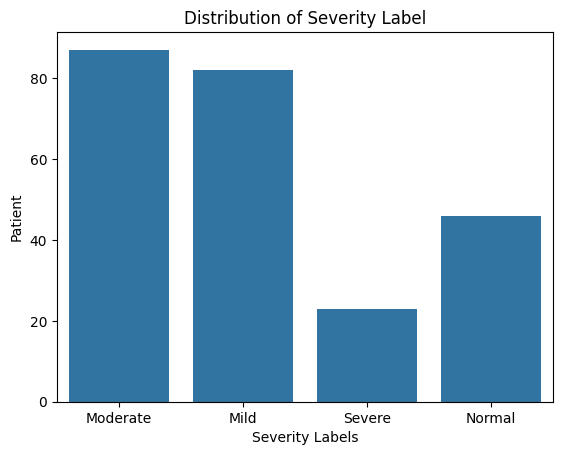

In [ ]:
# Plot the class distribution of the Severity_Label
sns.countplot(data=EMG_df, x='Severity_Label')
plt.title('Distribution of Severity Label')
plt.xlabel("Severity Labels")
plt.ylabel("Patient")
plt.show()

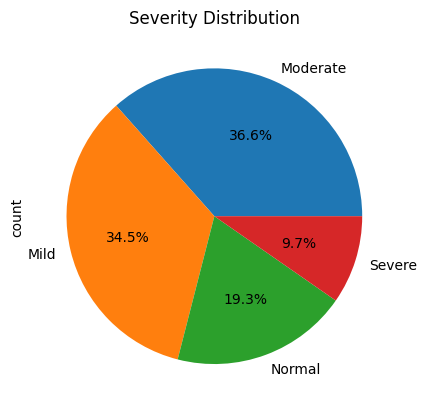

In [ ]:
# Pie chart for visualizing the percentage distribution of Severity_Label
EMG_df['Severity_Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Severity Distribution")
plt.show()

## Distribution of Each EMG Feature

### Numarical Features Distribution

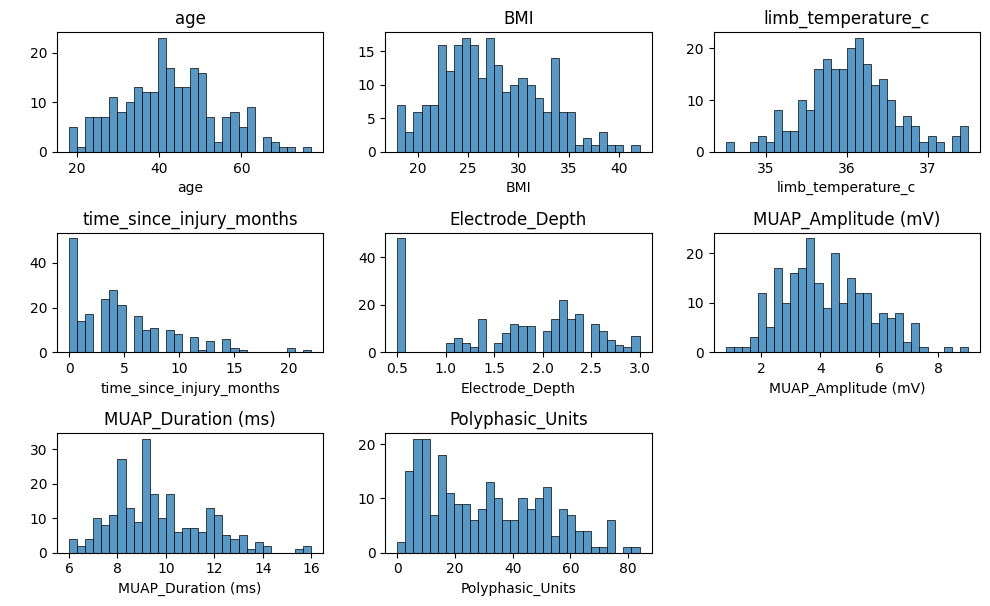

In [ ]:
# number of charts per row
cols = 3

# round up the number of rows ; Ensures enough rows to display all features.
rows = math.ceil( len(numeric_features) / cols)

# Create Creates a new figure for all subplots ( witdh,height  )
plt.figure(figsize=(10, rows * 2))


for i, col in enumerate(numeric_features, 1):
    #Creates the i-th subplot in a grid of rows × cols.
    plt.subplot(rows, cols, i)

    # draws histogram + dropna() removes missing values before plottin + splits the data range into 30 buckets +  no density curve
    sns.histplot(EMG_df[col].dropna(), bins=30, kde=False)
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)
    plt.ylabel(' ', fontsize=10)

plt.tight_layout()
plt.show()


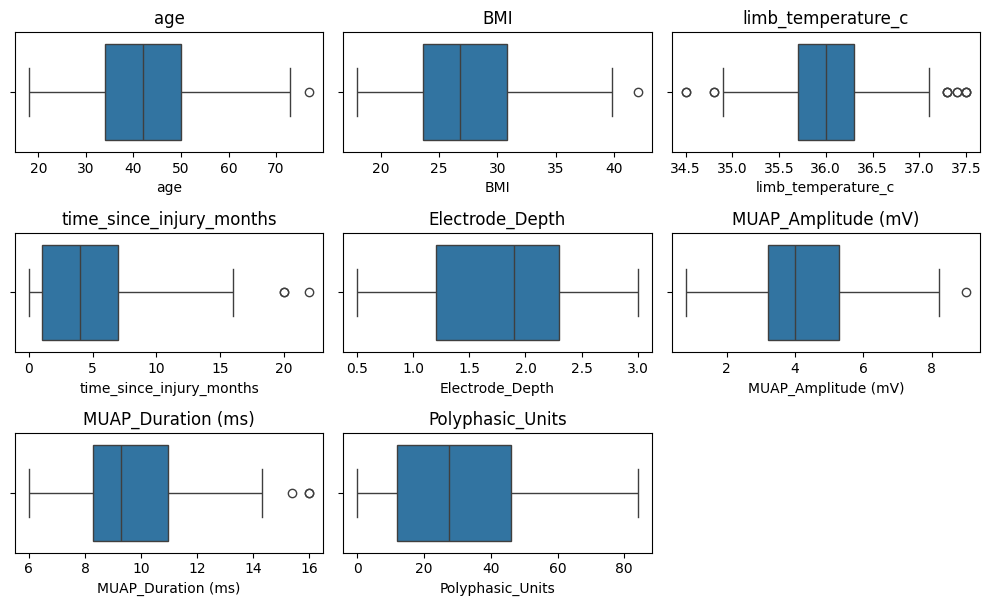

In [ ]:
#  Boxplot by Nerve or Severity

plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


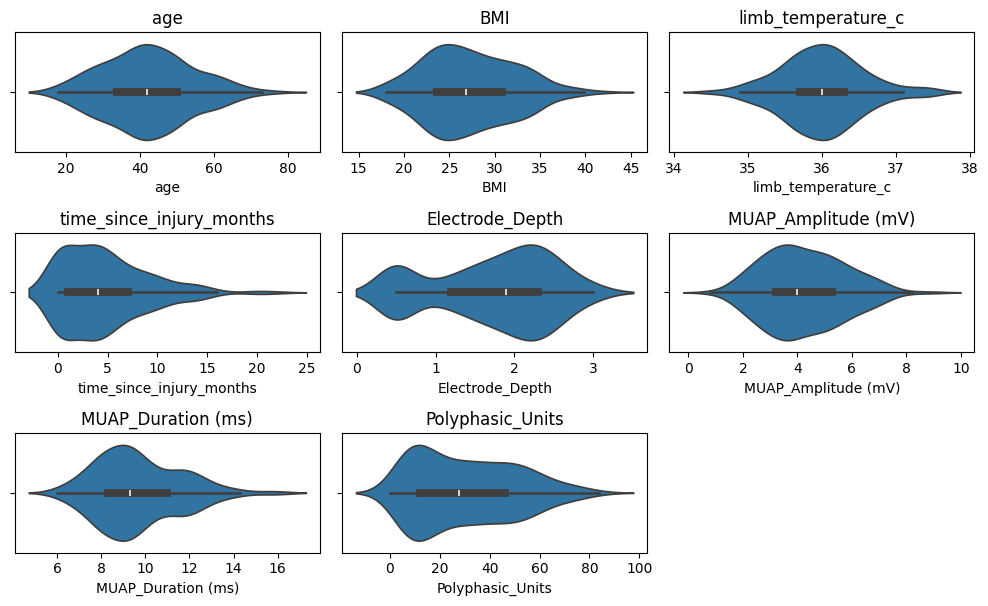

In [ ]:
# Violin plots for visualizing the distribution of all numeric features
plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.violinplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()

### Catagorical Features Distribution

/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

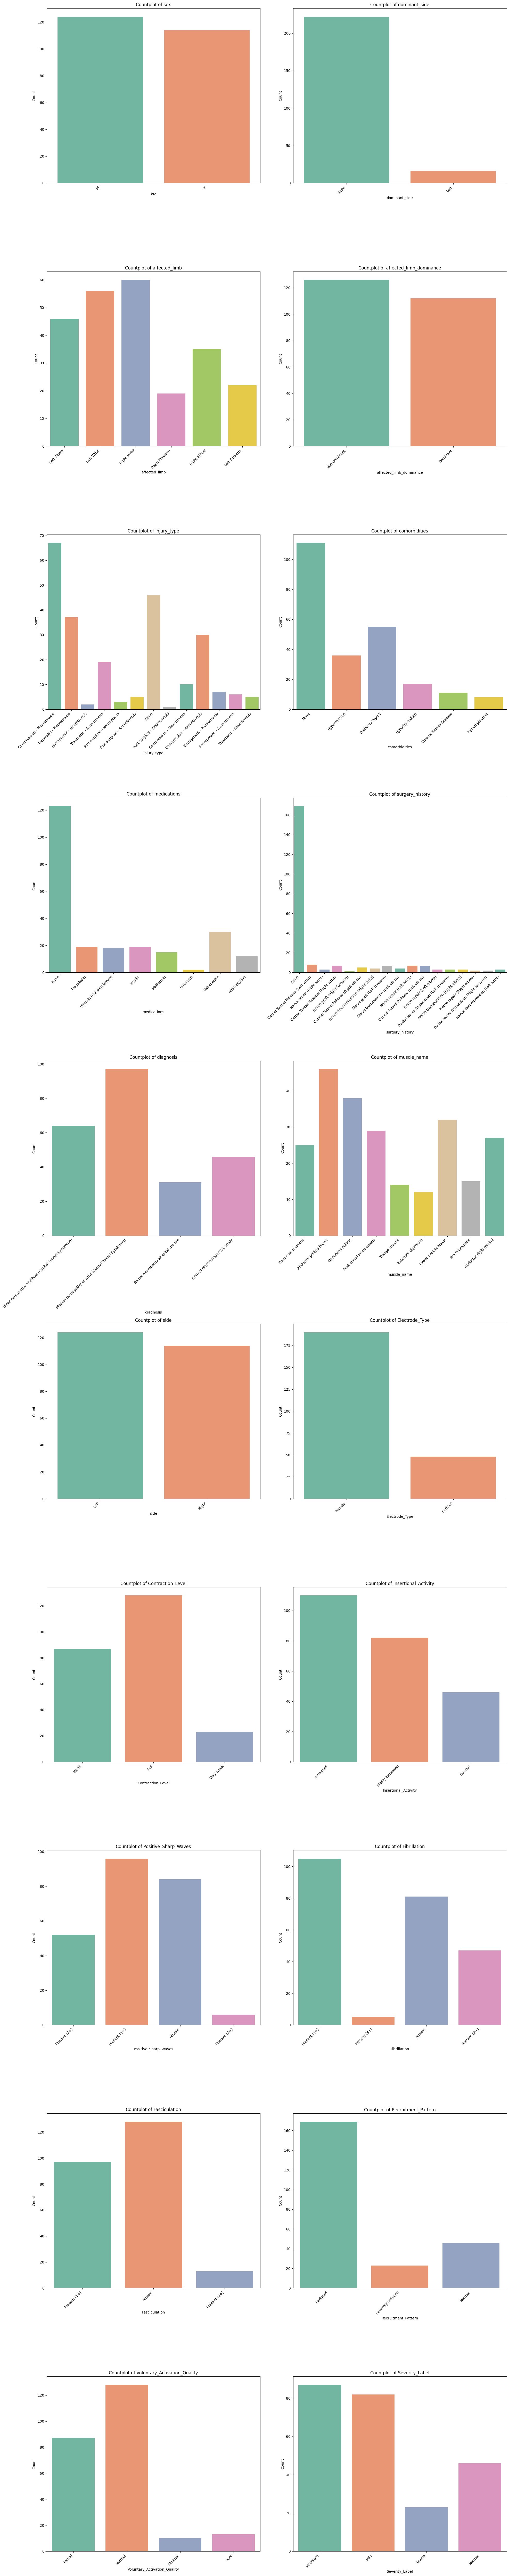

In [ ]:
# Count Plot

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Layout
cols = 2   # number of plots per row
rows = math.ceil(n_cat / cols)

# Create figure
plt.figure(figsize=(20, rows * 10))

# Loop for subplots
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=EMG_df, x=col, palette='Set2')
    plt.title(f'Countplot of {col}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


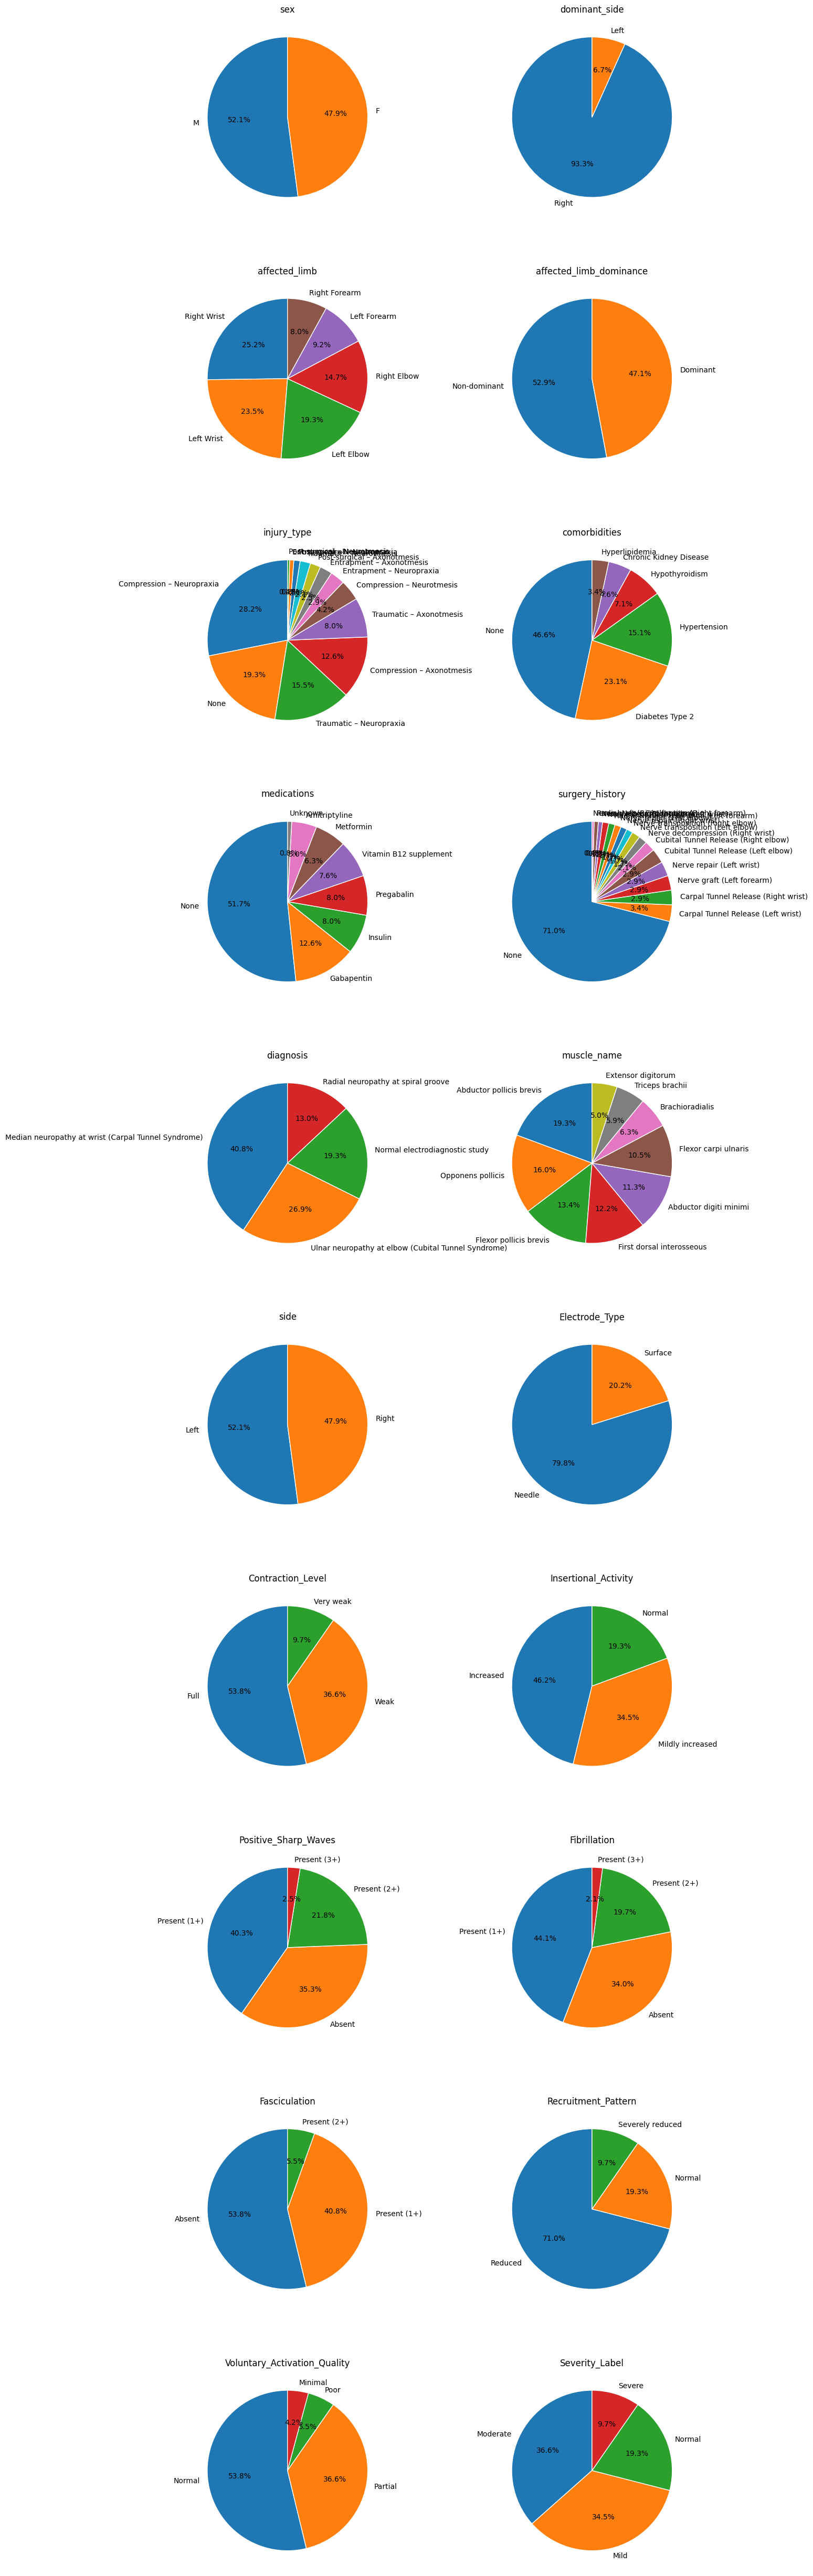

In [ ]:
# Pie chart

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Subplot layout
cols = 2
rows = math.ceil(n_cat / cols)

# Create the figure
plt.figure(figsize=(14, rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)

    # Get counts
    data = EMG_df[col].value_counts()

    # Pie chart
    plt.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'{col}', fontsize=12)

plt.tight_layout()
plt.show()


## Missing Values

In [ ]:
# Display missing (Unknown) values for numeric columns
print("Missing values per column:\n", EMG_df.isnull().sum())

Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  1
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            3
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     1
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [ ]:
# Display percentage of missing (Unknown) values for each column
missing_percent = (EMG_df.isnull().sum() / len(EMG_df)) * 100

print("Missing Values Percentage (%):\n")
print(missing_percent.sort_values(ascending=False))

Missing Values Percentage (%):

time_since_injury_months            1.260504
limb_temperature_c                  0.420168
Electrode_Depth                     0.420168
sex                                 0.000000
BMI                                 0.000000
dominant_side                       0.000000
affected_limb                       0.000000
ID                                  0.000000
affected_limb_dominance             0.000000
injury_type                         0.000000
comorbidities                       0.000000
medications                         0.000000
surgery_history                     0.000000
diagnosis                           0.000000
muscle_name                         0.000000
age                                 0.000000
side                                0.000000
Electrode_Type                      0.000000
Contraction_Level                   0.000000
Insertional_Activity                0.000000
Positive_Sharp_Waves                0.000000
Fibrillation           

In [ ]:
# Select only categorical (object / category) columns
cat_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Count "Unknown" per categorical column
unknown_per_col = {}

for col in cat_cols:
    # Convert to string, remove leading/trailing spaces, then compare
    count_unknown = EMG_df[col].astype("string").str.strip().eq("Unknown").sum()
    unknown_per_col[col] = count_unknown

# Print count for each column
print("Unknown count per categorical feature:\n")
for col, cnt in unknown_per_col.items():
    print(f"{col}: {cnt}")

# Total Unknown in all categorical features
total_unknown = sum(unknown_per_col.values())
print("\nTotal 'Unknown' in categorical features:", total_unknown)


Unknown count per categorical feature:

sex: 0
dominant_side: 0
affected_limb: 0
affected_limb_dominance: 0
injury_type: 0
comorbidities: 0
medications: 2
surgery_history: 0
diagnosis: 0
muscle_name: 0
side: 0
Electrode_Type: 0
Contraction_Level: 0
Insertional_Activity: 0
Positive_Sharp_Waves: 0
Fibrillation: 0
Fasciculation: 0
Recruitment_Pattern: 0
Voluntary_Activation_Quality: 0
Severity_Label: 0

Total 'Unknown' in categorical features: 2


In [ ]:
# Missing Percentage for Categorical Features
cat_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

missing_counts = {}

for col in cat_cols:
    count_unknown = EMG_df[col].astype("string").str.strip().eq("Unknown").sum()
    missing_counts[col] = count_unknown

missing_percent = {col: (cnt / len(EMG_df)) * 100 for col, cnt in missing_counts.items()}

missing_percent = dict(sorted(missing_percent.items(), key=lambda x: x[1], reverse=True))

print("Missing Percentage for Categorical Features (Unknown as Missing):\n")
for col, p in missing_percent.items():
    print(f"{col}: {p:.2f}%")


Missing Percentage for Categorical Features (Unknown as Missing):

medications: 0.84%
sex: 0.00%
dominant_side: 0.00%
affected_limb: 0.00%
affected_limb_dominance: 0.00%
injury_type: 0.00%
comorbidities: 0.00%
surgery_history: 0.00%
diagnosis: 0.00%
muscle_name: 0.00%
side: 0.00%
Electrode_Type: 0.00%
Contraction_Level: 0.00%
Insertional_Activity: 0.00%
Positive_Sharp_Waves: 0.00%
Fibrillation: 0.00%
Fasciculation: 0.00%
Recruitment_Pattern: 0.00%
Voluntary_Activation_Quality: 0.00%
Severity_Label: 0.00%


Missing % (Unknown):
 limb_temperature_c          0.420168
time_since_injury_months    1.260504
medications                 0.840336
Electrode_Depth             0.420168
dtype: float64


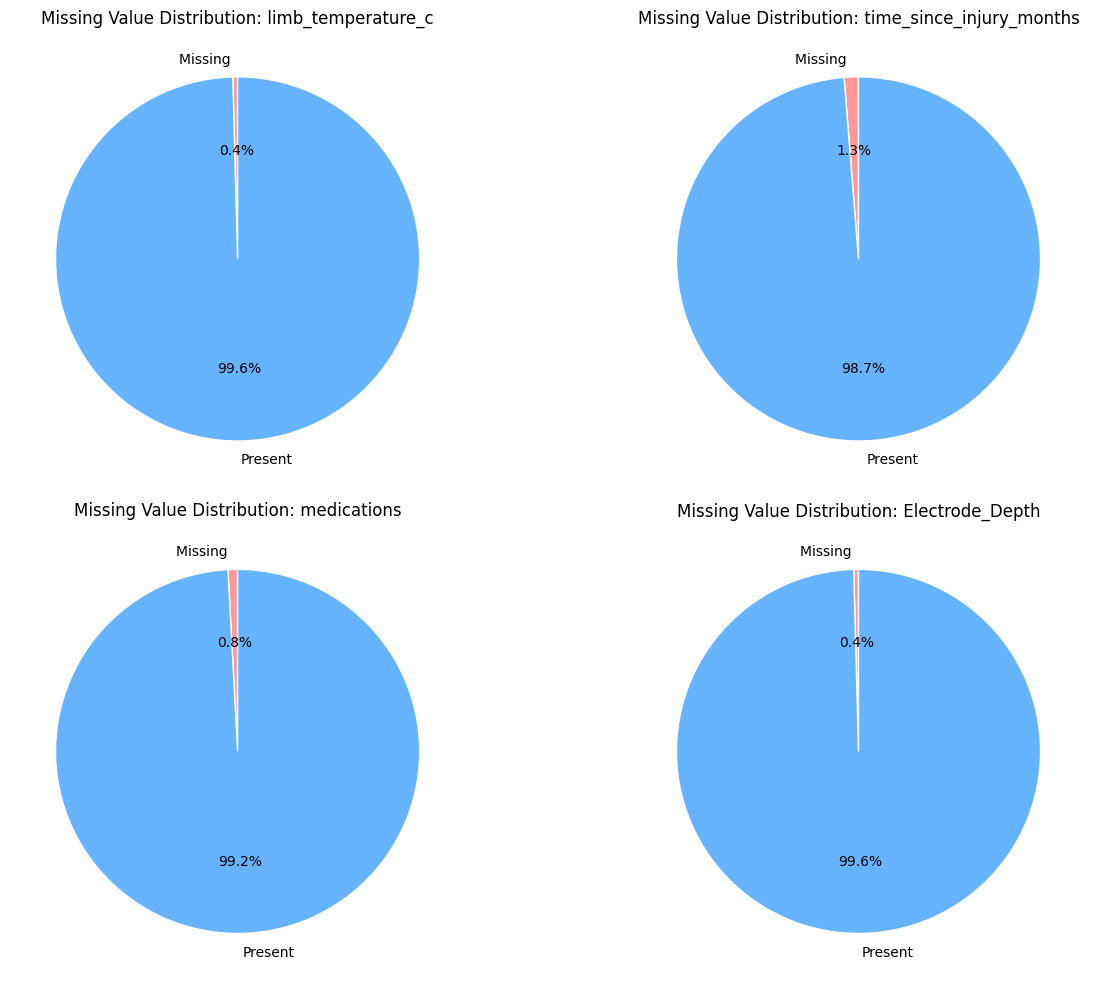

In [ ]:
#  Pie chart for Missing Values

# Missing values in numerical features
missing_counts = EMG_df.isnull().sum()

# Unknown counts for categorical features
cat_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    unknown_count = EMG_df[col].astype("string").str.strip().eq("Unknown").sum()
    missing_counts[col] += unknown_count   # treat Unknown as missing

# Convert to percentage
missing_percent = (missing_counts / len(EMG_df)) * 100

# Select features that actually have missing (Unknown)
missing_features = missing_percent[missing_percent > 0]

print("Missing % (Unknown):\n", missing_features)

# Subplots layout
n_features = len(missing_features)
cols = 2
rows = math.ceil(n_features / cols)

plt.figure(figsize=(14, rows * 5))

# Draw pie chart for each feature
for i, col in enumerate(missing_features.index, 1):
    plt.subplot(rows, cols, i)

    missing_count = missing_counts[col]
    present_count = len(EMG_df) - missing_count

    plt.pie(
        [missing_count, present_count],
        labels=['Missing ', 'Present'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff'],
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'Missing Value Distribution: {col}', fontsize=12)

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

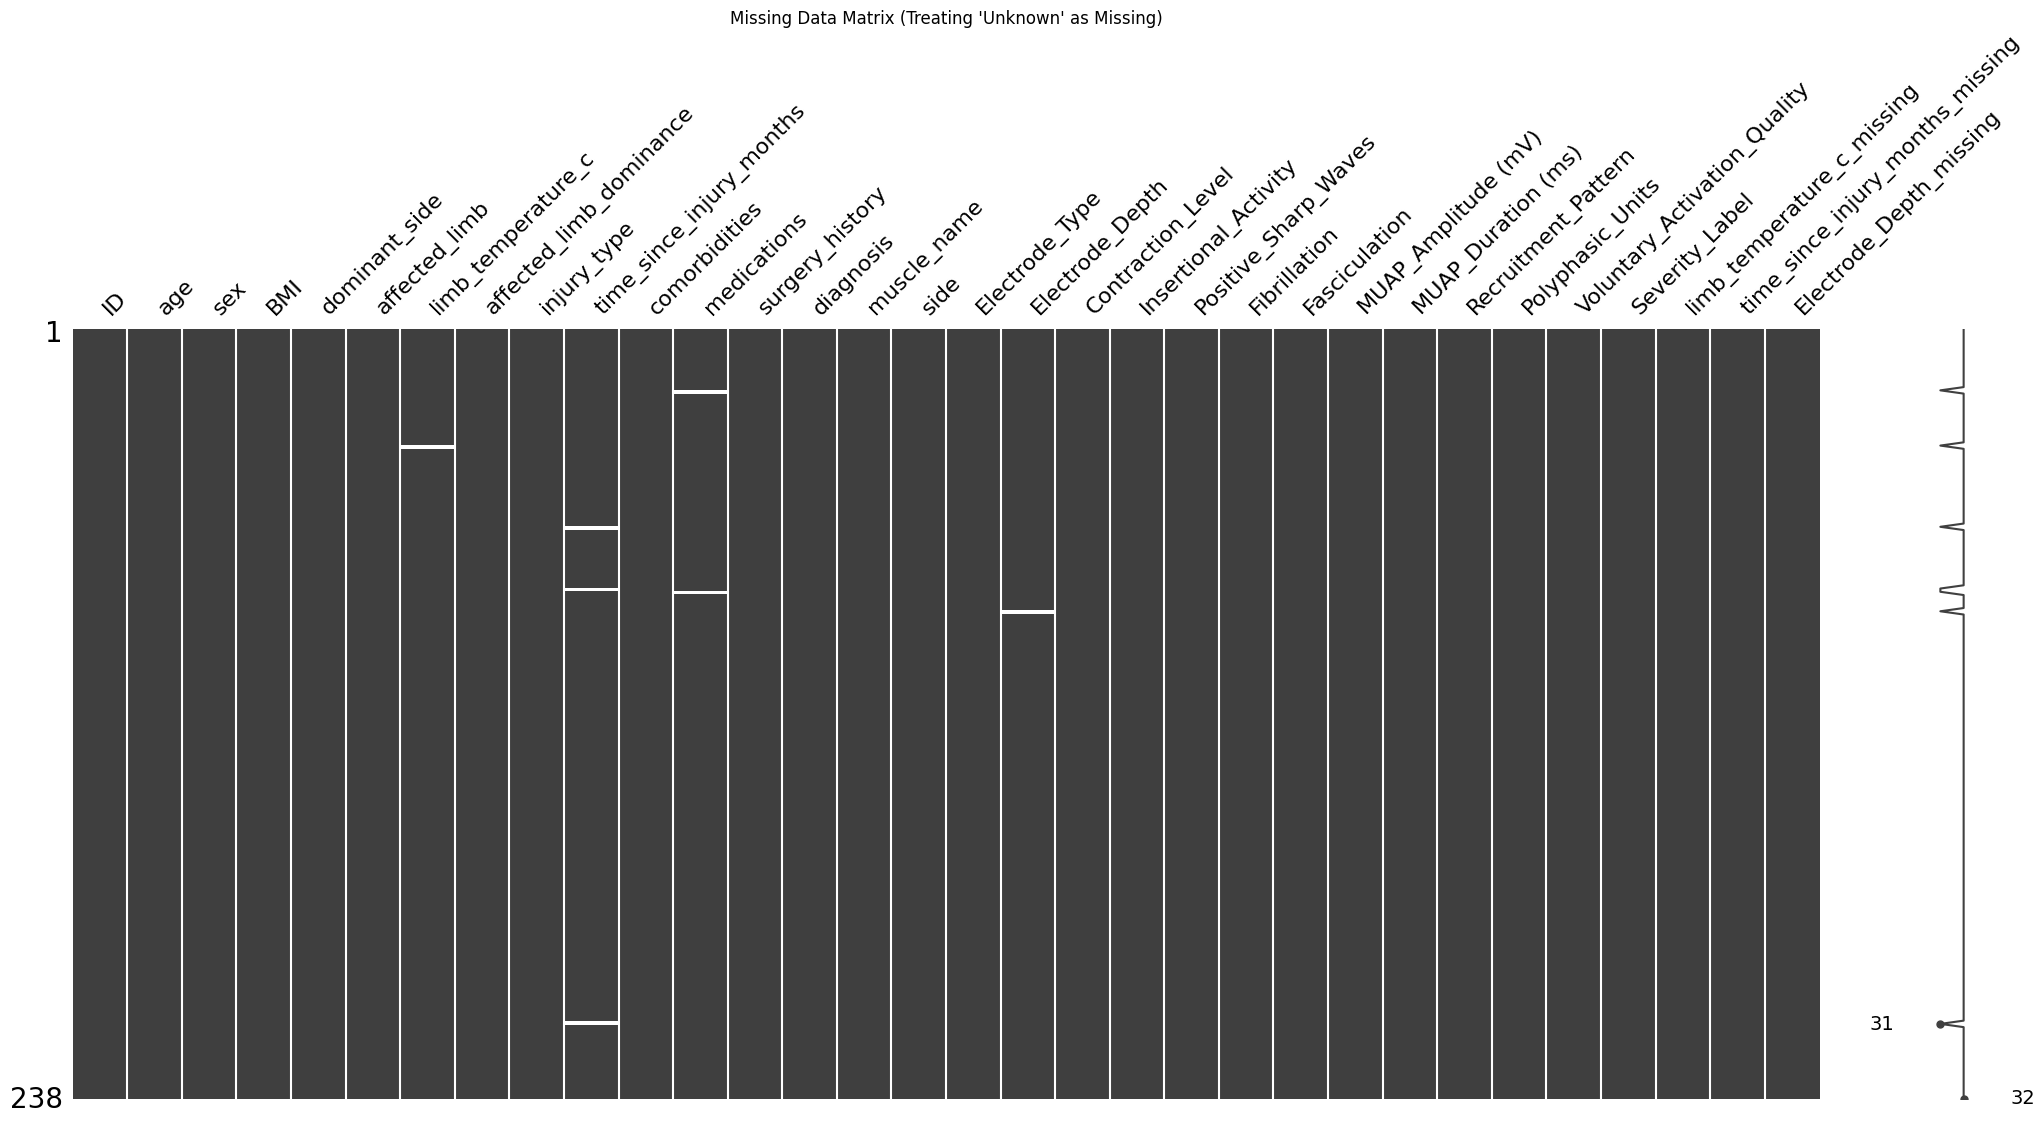

In [ ]:
# Treat 'Unknown' as missing in categorical columns and visualize missing data using Missingno
df_missing = EMG_df.copy()

cat_cols = df_missing.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    df_missing[col] = df_missing[col].astype("string").str.strip()
    df_missing[col] = df_missing[col].replace("Unknown", np.nan)

# Missingno
plt.figure(figsize=(12, 6))
msno.matrix(df_missing)
plt.title("Missing Data Matrix (Treating 'Unknown' as Missing)")
plt.show()

## Duplicates Recoreds


In [ ]:
# Check for fully duplicated rows in the dataset
dup_rows = EMG_df.duplicated().sum()
print("\nNumber of Fully Duplicated rows:", dup_rows)


Number of Fully Duplicated rows: 0


## Detecting Messy Format

In [ ]:
# Detect Non-Numeric Characters Inside Numeric Columns

for col in EMG_df.select_dtypes(include='object'):
    # Check if column is supposed to be numeric
    try:
        EMG_df[col].astype(float)
        print(f"POSSIBLE WRONG FORMAT → {col}: contains numeric-like strings")
    except:
        pass


In [ ]:
# Detect Leading / Trailing Spaces

for col in EMG_df.select_dtypes(include='object'):
    EMG_df[col] = EMG_df[col].astype(str)
    if EMG_df[col].str.contains(r'^\s+|\s+$').any():
        print(f"WARNING: Spaces in {col}")


In [ ]:
# Detect Mixed Formats

for col in EMG_df.select_dtypes(include='object'):
    print(f"\nUnique values in {col}:")
    print(EMG_df[col].unique())



Unique values in sex:
['M' 'F']

Unique values in dominant_side:
['Right' 'Left']

Unique values in affected_limb:
['Left Elbow' 'Left Wrist' 'Right Wrist' 'Right Forearm' 'Right Elbow'
 'Left Forearm']

Unique values in affected_limb_dominance:
['Non-dominant' 'Dominant']

Unique values in injury_type:
['Compression – Neuropraxia' 'Traumatic – Neuropraxia'
 'Entrapment – Neurotmesis' 'Traumatic – Axonotmesis'
 'Post-surgical – Neuropraxia' 'Post-surgical – Axonotmesis' 'None'
 'Post-surgical – Neurotmesis' 'Compression – Neurotmesis'
 'Compression – Axonotmesis' 'Entrapment – Neuropraxia'
 'Entrapment – Axonotmesis' 'Traumatic – Neurotmesis']

Unique values in comorbidities:
['None' 'Hypertension' 'Diabetes Type 2' 'Hypothyroidism'
 'Chronic Kidney Disease' 'Hyperlipidemia']

Unique values in medications:
['None' 'Pregabalin' 'Vitamin B12 supplement' 'Insulin' 'Metformin'
 'Unknown' 'Gabapentin' 'Amitriptyline']

Unique values in surgery_history:
['None' 'Carpal Tunnel Release (Left 

In [ ]:
# Detect Unexpected / Invalid Categories

for col in EMG_df.select_dtypes(include='object'):
    print(f"\n{col} → unique values:")
    print(EMG_df[col].value_counts(dropna=False))



sex → unique values:
sex
M    124
F    114
Name: count, dtype: int64

dominant_side → unique values:
dominant_side
Right    222
Left      16
Name: count, dtype: int64

affected_limb → unique values:
affected_limb
Right Wrist      60
Left Wrist       56
Left Elbow       46
Right Elbow      35
Left Forearm     22
Right Forearm    19
Name: count, dtype: int64

affected_limb_dominance → unique values:
affected_limb_dominance
Non-dominant    126
Dominant        112
Name: count, dtype: int64

injury_type → unique values:
injury_type
Compression – Neuropraxia      67
None                           46
Traumatic – Neuropraxia        37
Compression – Axonotmesis      30
Traumatic – Axonotmesis        19
Compression – Neurotmesis      10
Entrapment – Neuropraxia        7
Entrapment – Axonotmesis        6
Post-surgical – Axonotmesis     5
Traumatic – Neurotmesis         5
Post-surgical – Neuropraxia     3
Entrapment – Neurotmesis        2
Post-surgical – Neurotmesis     1
Name: count, dtype: int6

In [ ]:
# Detect Columns with Mixed Types

for col in EMG_df.columns:
    types = EMG_df[col].apply(type).value_counts()
    if len(types) > 1:
        print(f"Mixed types in {col}: {types}")


In [ ]:
# Detect Out-of-range Values (Medical Logic Rules)

print((EMG_df["age"] < 0).sum(), "negative ages")
print((EMG_df["limb_temperature_c"] > 45).sum(), "invalid temperatures")
print((EMG_df["MUAP_Amplitude (mV)"] < 0).sum(), "negative EMG amplitude")


0 negative ages
0 invalid temperatures
0 negative EMG amplitude


In [ ]:
# Detect Symbols or Patterns in Categorical Columns

import re

for col in EMG_df.select_dtypes(include='object'):
    if EMG_df[col].str.contains(r'\(|\)|\+|\-').any():
        print(f"Possible encoded scale in {col}")


Possible encoded scale in affected_limb_dominance
Possible encoded scale in injury_type
Possible encoded scale in surgery_history
Possible encoded scale in diagnosis
Possible encoded scale in Positive_Sharp_Waves
Possible encoded scale in Fibrillation
Possible encoded scale in Fasciculation


## Detecting Outliers



### IQR

In [ ]:
'''
  - Fourmla:
        IQR = Q3 − Q1
        [Q1−1.5× IQR , Q3+1.5×IQR]
'''

Q1 = EMG_df[numeric_cols].quantile(0.25)
Q3 = EMG_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask of outliers (True = outlier)
outlier_mask = (EMG_df[numeric_cols] < lower_bound) | (EMG_df[numeric_cols] > upper_bound)

# Number of rows with at least one outlier
print("IQR Outlier Rows:", outlier_mask.any(axis=1).sum())

# List rows + feature names
for idx in outlier_mask.any(axis=1).index[outlier_mask.any(axis=1)]:
    feats = list(outlier_mask.columns[outlier_mask.loc[idx]])
    print(f"Row {idx}: {feats}")


IQR Outlier Rows: 21
Row 27: ['time_since_injury_months']
Row 40: ['limb_temperature_c']
Row 49: ['BMI']
Row 52: ['time_since_injury_months']
Row 74: ['MUAP_Duration (ms)']
Row 83: ['limb_temperature_c']
Row 96: ['MUAP_Duration (ms)']
Row 104: ['limb_temperature_c']
Row 131: ['MUAP_Duration (ms)']
Row 143: ['time_since_injury_months']
Row 152: ['limb_temperature_c']
Row 163: ['MUAP_Amplitude (mV)']
Row 164: ['limb_temperature_c']
Row 177: ['age']
Row 180: ['limb_temperature_c']
Row 187: ['limb_temperature_c']
Row 192: ['limb_temperature_c']
Row 196: ['limb_temperature_c']
Row 197: ['limb_temperature_c']
Row 198: ['limb_temperature_c']
Row 228: ['limb_temperature_c']


### MAD:  Median Absolute Deviation




In [ ]:
'''
  MAD: Median Absolute Deviation (Robust Z-score)

  Why MAD?
  - Z-score uses mean and std → very sensitive to outliers
  - MAD uses median → resistant to extreme values

  - formula:
       Z_robust = 0.6745 * (x - median) / MAD

  - Outlier If:
       |Z_robust| > threshold

  - Common threshold = 3.5 (more robust than Z-score=3)
'''

threshold = 3.5

# Compute median and MAD per numeric feature
median_vals = EMG_df[numeric_cols].median()
mad_vals = EMG_df[numeric_cols].apply(median_abs_deviation)

# Smoothing: Avoid division by zero by replacing MAD=0 with a tiny value
mad_vals = mad_vals.replace(0, 1e-9)

# Compute Robust Z-score
df_mad = 0.6745 * (EMG_df[numeric_cols] - median_vals) / mad_vals

# Boolean mask of outliers
outlier_flags = df_mad.abs() > threshold

# Count outliers per row
outlier_mask = outlier_flags.sum(axis=1)


# Results
print(f"Rows with > {threshold} MAD deviations:", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")

for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")


Rows with > 3.5 MAD deviations: 2

=== Outlier Rows and Feature Names ===

Row 74: ['MUAP_Duration (ms)']
Row 131: ['MUAP_Duration (ms)']


### Z-Score

In [ ]:
'''
  in Gaussian Normal Distribution:
  - 68% of data  within   +-1 std
  - 95% is within         +- 2 std
  - 99.7% is within       += 3 std   ;  Anything beyond ±3 std is Outli

'''
#  Z-score threshold
std = 2

# Compute Z-scores only for numeric columns
df_z = EMG_df[numeric_cols].apply(zscore)


# Find outliers per row (True/False mask)
outlier_flags = df_z.abs() > std


# Count number of outliers per row
outlier_mask = outlier_flags.sum(axis=1)

# results
print("Rows with >",std," Standard Deviations:  ", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")
for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")

Rows with > 2  Standard Deviations:   39

=== Outlier Rows and Feature Names ===

Row 2: ['BMI', 'MUAP_Duration (ms)']
Row 9: ['BMI']
Row 13: ['MUAP_Amplitude (mV)']
Row 18: ['age']
Row 25: ['BMI']
Row 32: ['age']
Row 36: ['Polyphasic_Units']
Row 49: ['BMI']
Row 59: ['Polyphasic_Units']
Row 64: ['MUAP_Amplitude (mV)']
Row 66: ['BMI']
Row 73: ['MUAP_Amplitude (mV)']
Row 74: ['MUAP_Duration (ms)']
Row 81: ['Polyphasic_Units']
Row 96: ['MUAP_Duration (ms)']
Row 111: ['MUAP_Amplitude (mV)']
Row 124: ['age']
Row 131: ['MUAP_Duration (ms)']
Row 133: ['age']
Row 137: ['Polyphasic_Units']
Row 143: ['age']
Row 148: ['MUAP_Duration (ms)']
Row 162: ['MUAP_Duration (ms)']
Row 163: ['MUAP_Amplitude (mV)']
Row 170: ['age']
Row 172: ['MUAP_Duration (ms)']
Row 177: ['age']
Row 191: ['MUAP_Amplitude (mV)', 'Polyphasic_Units']
Row 194: ['BMI']
Row 202: ['Polyphasic_Units']
Row 204: ['BMI']
Row 211: ['BMI', 'MUAP_Amplitude (mV)']
Row 214: ['age']
Row 216: ['age']
Row 224: ['age']
Row 231: ['age']
Row 232

# **------------------------------- Preprocessing ---------------------------------**

## Handle Missing Values (Unknown → NaN, Missing Indicators, Imputation)

In [ ]:
# Fill missing numeric values (including 'Unknown') with the median of each column
for col in numeric_fix_cols:
    median_val = EMG_df[col].median()
    EMG_df[col].fillna(median_val, inplace=True)


/tmp/ipython-input-1391843294.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  EMG_df[col].fillna(median_val, inplace=True)


In [ ]:
# Recheck missing values after filling numeric columns
print("Missing values per column:\n", EMG_df.isnull().sum())

Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  0
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            0
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     0
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [ ]:
# Target columns
target_cols = ['Severity_Label']

# Reorder: (all other columns) + (target columns)
EMG_df = EMG_df[[col for col in EMG_df.columns if col not in target_cols] + target_cols]

In [ ]:
# Display the first few rows with full column visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

EMG_df.head()

ID  age sex   BMI dominant_side affected_limb  limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                37.0   
1   2   41   F  33.7         Right    Left Wrist                35.8   
2   3   24   M  37.1         Right   Right Wrist                35.7   
3   4   52   M  26.4         Right   Right Wrist                36.0   
4   5   47   M  25.9         Right   Right Wrist                35.7   

  affected_limb_dominance                injury_type  \
0            Non-dominant  Compression – Neuropraxia   
1            Non-dominant    Traumatic – Neuropraxia   
2                Dominant   Entrapment – Neurotmesis   
3                Dominant  Compression – Neuropraxia   
4                Dominant    Traumatic – Axonotmesis   

   time_since_injury_months    comorbidities             medications  \
0                       1.0             None                    None   
1                       5.0     Hypertension              Pregabalin   
2                      10.0  Diabetes Type 2  Vitamin B12 supplement   
3                       6.0  Diabetes Type 2                 Insulin   
4                      10.0             None              Pregabalin   

                      surgery_history  \
0                                None   
1  Carpal Tunnel Release (Left wrist)   
2                                None   
3                                None   
4                                None   

                                             diagnosis  \
0  Ulnar neuropathy at elbow (Cubital Tunnel Syndrome)   
1  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
2  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
3  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
4  Median neuropathy at wrist (Carpal Tunnel Syndrome)   

                muscle_name   side Electrode_Type  Electrode_Depth  \
0      Flexor carpi ulnaris   Left         Needle              1.6   
1  Abductor pollicis brevis   Left         Needle              2.4   
2  Abductor pollicis brevis  Right         Needle              2.5   
3         Opponens pollicis  Right         Needle              1.0   
4  Abductor pollicis brevis  Right        Surface              0.5   

  Contraction_Level Insertional_Activity Positive_Sharp_Waves  Fibrillation  \
0              Weak            Increased         Present (2+)  Present (1+)   
1              Full     Mildly increased         Present (1+)  Present (1+)   
2         Very weak            Increased         Present (2+)  Present (1+)   
3              Weak            Increased         Present (1+)  Present (1+)   
4         Very weak            Increased         Present (1+)  Present (3+)   

  Fasciculation  MUAP_Amplitude (mV)  MUAP_Duration (ms) Recruitment_Pattern  \
0  Present (1+)                  3.3                 9.1             Reduced   
1        Absent                  5.2                 9.2             Reduced   
2  Present (1+)                  1.9                14.2    Severely reduced   
3  Present (1+)                  3.7                10.9             Reduced   
4  Present (2+)                  1.5                 9.0    Severely reduced   

   Polyphasic_Units Voluntary_Activation_Quality  limb_temperature_c_missing  \
0                43                      Partial                       False   
1                23                       Normal                       False   
2                61                      Minimal                       False   
3                41                      Partial                       False   
4                35                      Minimal                       False   

   time_since_injury_months_missing  Electrode_Depth_missing Severity_Label  
0                             False                    False       Moderate  
1                             False                    False           Mild  
2                             False                    False         Severe  
3                             Fals

##Drop Non-Informative Columns

In [ ]:
# Drop non-informative columns before modeling
drop_cols = [
    'ID',
    'comorbidities',
    'medications',
    'surgery_history',
    'diagnosis'

]
EMG_df = EMG_df.drop(columns=drop_cols)

print("Shape AFTER basic drops:", EMG_df.shape)
print(EMG_df.columns.tolist())


Shape AFTER basic drops: (238, 27)
['age', 'sex', 'BMI', 'dominant_side', 'affected_limb', 'limb_temperature_c', 'affected_limb_dominance', 'injury_type', 'time_since_injury_months', 'muscle_name', 'side', 'Electrode_Type', 'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern', 'Polyphasic_Units', 'Voluntary_Activation_Quality', 'limb_temperature_c_missing', 'time_since_injury_months_missing', 'Electrode_Depth_missing', 'Severity_Label']


# **Encoding**

### Label Encoding (Binary Encoding)


In [ ]:
# Convert binary categorical features into numeric 0/1 encoding
binary_mappings = {
    'sex': {'M': 1, 'F': 0},
    'dominant_side': {'Right': 1, 'Left': 0},
    'affected_limb_dominance': {'Dominant': 1, 'Non-dominant': 0},
    'side': {'Right': 1, 'Left': 0},
    'Electrode_Type': {'Needle': 1, 'Surface': 0}
}

for col, mapping in binary_mappings.items():
    EMG_df[col] = EMG_df[col].map(mapping)

### Ordinal Encoding For The Label

In [ ]:
# Encode the target variable (Severity_Label) into ordered numeric classes
severity_map = {
    'Normal'  : 0,
    'Mild'    : 1,
    'Moderate': 2,
    'Severe'  : 3
}
EMG_df['Severity_Label'] = EMG_df['Severity_Label'].map(severity_map).astype(int)


##categorical encoding






In [ ]:
#Feature Encoding: Ordinal Mapping

# Define fixed order for ALL ordinal features
ordinal_maps = {

    'Contraction_Level': {
        'Full': 0,
        'Weak': 1,
        'Very weak': 2,
    },
    'Recruitment_Pattern': {
        'Normal': 0,
        'Reduced': 1,
        'Severely reduced': 2
    },
    'Voluntary_Activation_Quality': {
        'Normal': 0,
        'Partial': 1,
        'Minimal': 2,
        'Poor': 3
    },

    'Insertional_Activity': {
        'Normal': 0,
        'Mildly increased': 1,
        'Increased': 2
    },
    'Fasciculation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2
    },
    'Positive_Sharp_Waves': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    },
    'Fibrillation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    }
}

# Apply Ordinal Encoding
for col, mapping in ordinal_maps.items():
    # Use .map() to apply the dictionary and .astype(int) to ensure integer type
    EMG_df[col] = EMG_df[col].map(mapping).astype(int)

print("All Ordinal features, including severity grades, are now correctly encoded.")

All Ordinal features, including severity grades, are now correctly encoded.


# **Correlation Analysis**

# Correlation Matrix

Numeric columns used in correlation:
['age', 'sex', 'BMI', 'dominant_side', 'affected_limb', 'limb_temperature_c', 'affected_limb_dominance', 'injury_type', 'time_since_injury_months', 'muscle_name', 'side', 'Electrode_Type', 'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern', 'Polyphasic_Units', 'Voluntary_Activation_Quality', 'Severity_Label']


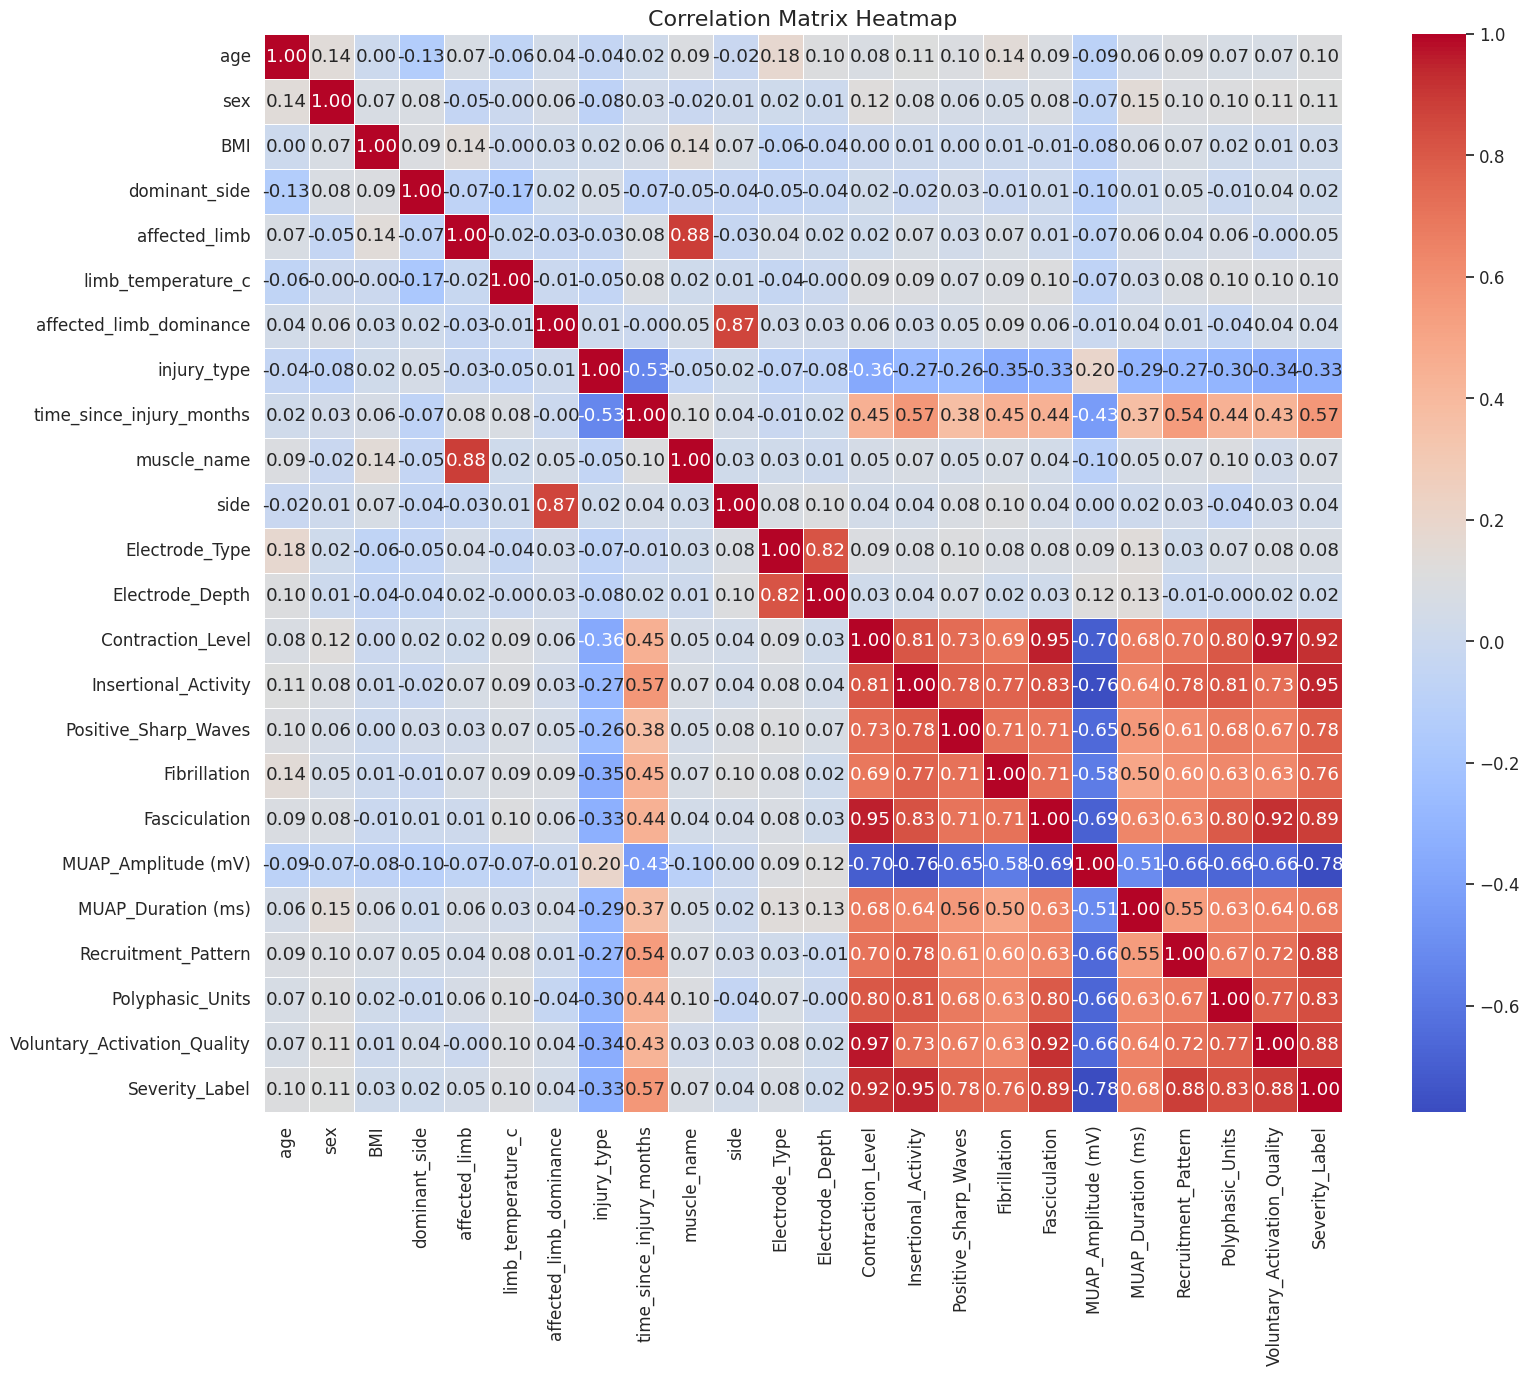

In [ ]:
# Prepare numeric features for correlation analysis (including frequency-encoded nominal features)
sns.set(style="whitegrid", font_scale=1.1)

df_corr = EMG_df.copy()

# Apply frequency encoding to selected nominal columns
freq_cols = ['affected_limb', 'injury_type', 'muscle_name']
for col in freq_cols:
    freq = df_corr[col].value_counts(normalize=True)
    df_corr[col] = df_corr[col].map(freq)

# Extract numeric-only columns for correlation matrix
numeric_df = df_corr.select_dtypes(include=["int64", "float64"]).copy()
numeric_df = numeric_df.drop(columns=["ID"], errors="ignore")

print("Numeric columns used in correlation:")
print(list(numeric_df.columns))

# Plot correlation heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()


# Correlation Matrix After Removing Selected Clinical Features


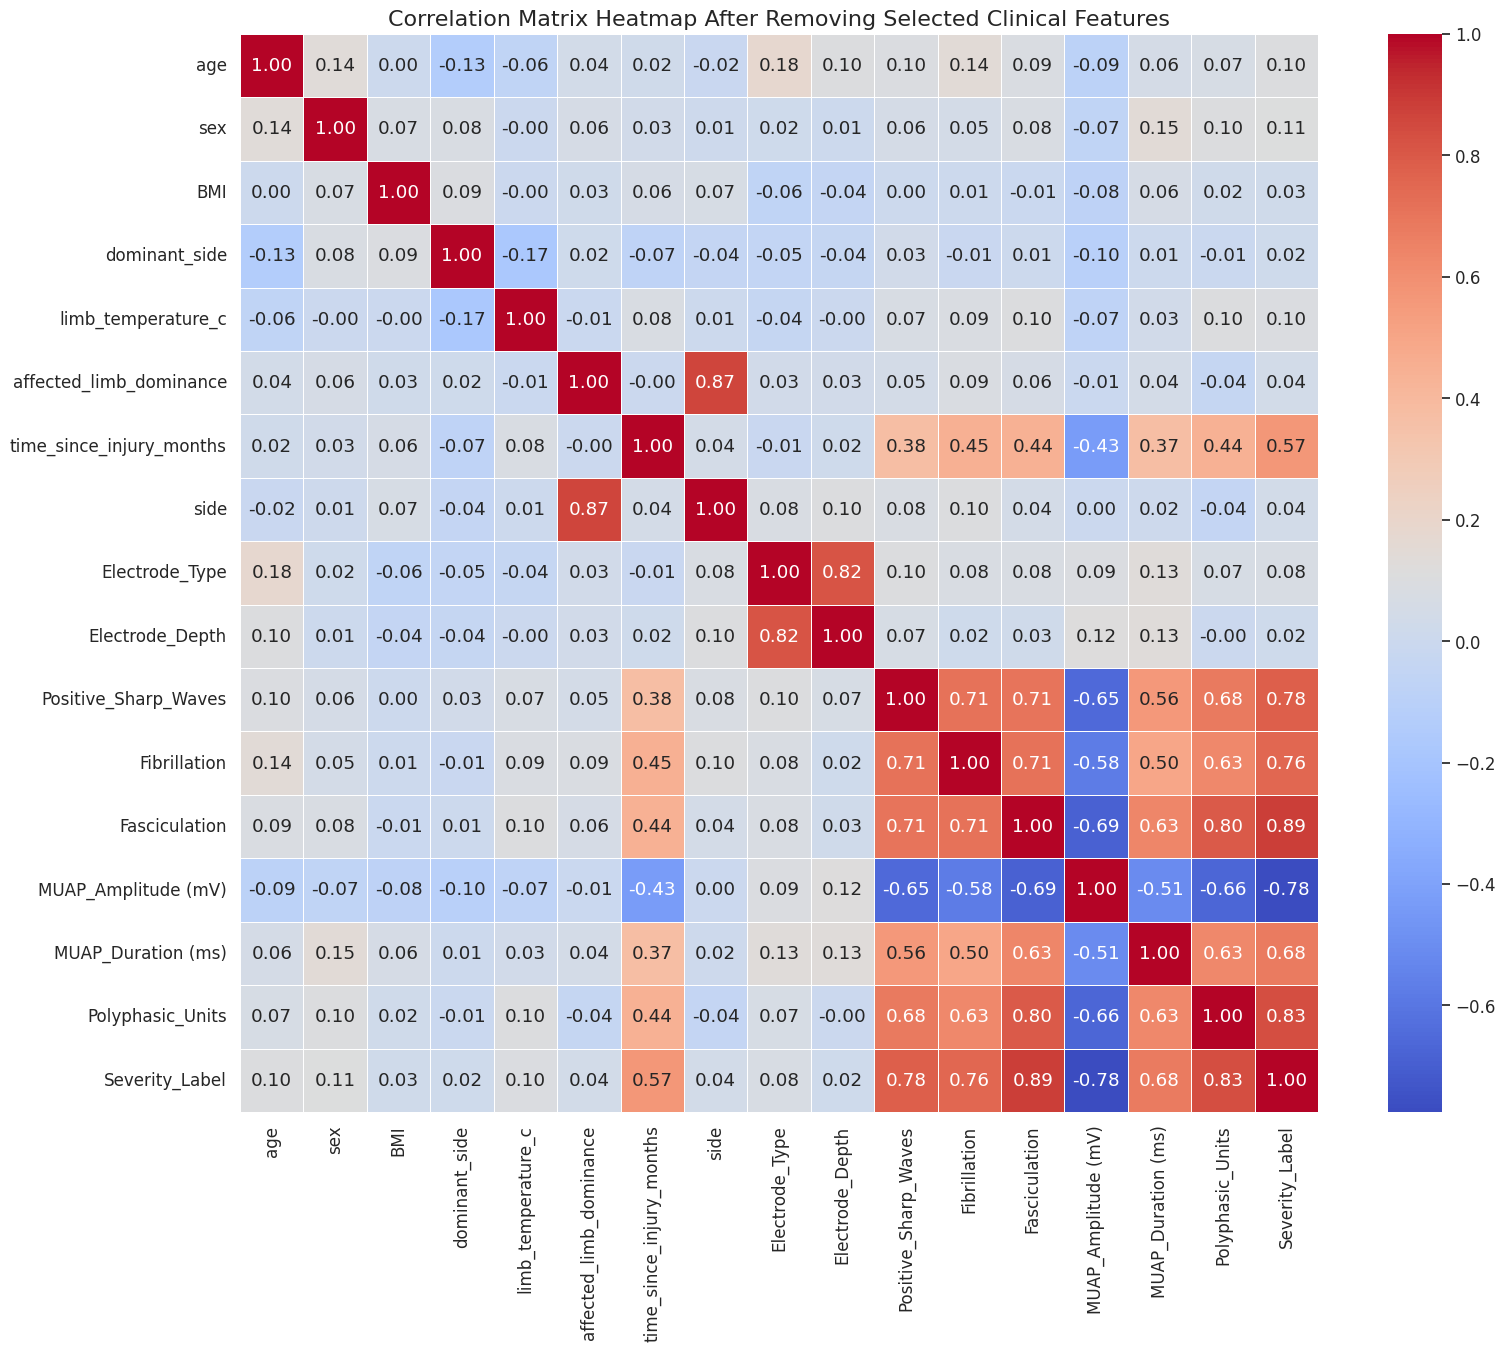

In [ ]:
# Remove clinical features that cause data leakage and recompute correlation matrix
cols_to_remove = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

df_corr_removed = EMG_df.drop(columns=cols_to_remove, errors="ignore")

numeric_df_removed = df_corr_removed.select_dtypes(include=["int64", "float64"])
numeric_df_removed = numeric_df_removed.drop(columns=["ID"], errors="ignore")

# Correlation Matrix After Removing Selected Clinical Features
plt.figure(figsize=(18, 14))
sns.heatmap(
    numeric_df_removed.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix Heatmap After Removing Selected Clinical Features", fontsize=16)
plt.show()


#**------------------- Model Implementation - SVM RBF ----------------------**

# **Preliminary Experiments (Before Removing Leakage Features)**

# Split

In [ ]:
# Split the dataset into training and testing sets (80/20) with stratification to preserve class balance
X_full = EMG_df.drop("Severity_Label", axis=1)
y_full = EMG_df["Severity_Label"]

X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)



In [ ]:
# Identify nominal (frequency encoded) columns
freq_cols = [
    'affected_limb', 'injury_type', 'muscle_name'
]

# SVM RBF Pipeline


In [ ]:
# SVM RBF Pipeline (Imputer + Scaler + SVM)
svm_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    ))
])


##Stratified 5-Fold Cross-Validation

* without feature selection
* using ( class weight ) to handle imbalance


In [ ]:
# 5-fold stratified cross-validation setup to preserve class balance across folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

In [ ]:
for train_idx, val_idx in skf.split(X_train_full, y_train_full):
    print(f"\n Fold {fold}")

    # TRAIN FULL
    X_train, X_val = X_train_full.iloc[train_idx].copy(), X_train_full.iloc[val_idx].copy()
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    # Frequency Encoding Only on TRAIN
    for col in freq_cols:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_val[col]   = X_val[col].map(freq).fillna(0)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # Train SVM
    svm_pipeline.fit(X_train_scaled, y_train)

    # Predict on validation fold
    y_pred = svm_pipeline.predict(X_val_scaled)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    print("Accuracy:", acc)
    print(classification_report(y_val, y_pred))

    fold += 1


 Fold 1
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00         3

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


 Fold 2
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         4

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


 Fold 3
Accuracy: 1.0
              precision    recall  f1-score   support

      

In [ ]:
print("\nCV Accuracy per fold:", accuracies)
print("CV Average Accuracy:", np.mean(accuracies))


CV Accuracy per fold: [1.0, 1.0, 1.0, 1.0, 1.0]
CV Average Accuracy: 1.0


# Hyperparameter Tuning for SVM RBF - GridSearchCV

In [ ]:
# Copy TRAIN-FULL
X_train_gs = X_train_full.copy()
y_train_gs = y_train_full.copy()

# Frequency Encoding for nominal columns (on TRAIN-FULL)
freq_cols = ['affected_limb', 'injury_type', 'muscle_name']

for col in freq_cols:
    freq = X_train_gs[col].value_counts(normalize=True)
    X_train_gs[col] = X_train_gs[col].map(freq).fillna(0.0)

# Convert *_missing flags from bool -> int (0/1)
missing_cols = [
    'limb_temperature_c_missing',
    'time_since_injury_months_missing',
    'Electrode_Depth_missing'
]

for col in missing_cols:
    print(col, "unique values before:", X_train_gs[col].unique())
    X_train_gs[col] = X_train_gs[col].map({True: 1, False: 0})

# Just to be safe: enforce int dtype
X_train_gs[missing_cols] = X_train_gs[missing_cols].astype(int)

# Check that all columns are numeric now
print("Non-numeric columns in X_train_gs:",
      X_train_gs.select_dtypes(exclude=['int64', 'float64']).columns.tolist())


limb_temperature_c_missing unique values before: [False  True]
time_since_injury_months_missing unique values before: [False  True]
Electrode_Depth_missing unique values before: [False  True]
Non-numeric columns in X_train_gs: []


In [ ]:
# Build Pipeline (Imputer + Scaler + SVM RBF)
#    Note: C and gamma will be tuned by GridSearch
svm_base_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle missing values
    ("scaler", StandardScaler()),                    # scale features
    ("svm", SVC(                                     # SVM model
        kernel="rbf",
        class_weight="balanced"                      # handle class imbalance
    ))
])

# Hyperparameter Search Grid
param_grid = {
    "svm__C":     [0.01, 0.1, 1, 10, 100],           # regularization strength
    "svm__gamma": ['scale',0.001, 0.01, 0.1, 1]              # RBF kernel width
}

# GridSearchCV (5-Fold Cross Validation)
grid_rbf = GridSearchCV(
    estimator=svm_base_pipeline,
    param_grid=param_grid,
    cv=5,                      # 5-fold CV
    scoring="accuracy",        # metric
    n_jobs=-1                  # use all CPU cores
)

# Fit on TRAINING ONLY (no test leakage)
grid_rbf.fit(X_train_gs, y_train_gs)

# Show best hyperparameters and best CV performance
print("Best parameters (RBF):", grid_rbf.best_params_)
print("Best CV accuracy:", grid_rbf.best_score_)


Best parameters (RBF): {'svm__C': 1, 'svm__gamma': 'scale'}
Best CV accuracy: 1.0


# Testing Model Stability Across Different Random States

In [ ]:
seeds = [1, 7, 21, 42, 99]

print("\n----- Testing Model Stability Across Different Random States (on TRAIN_FULL only) -----")

for seed in seeds:
    print(f"\nEvaluating with random_state = {seed} ...")

    # Split only the TRAIN part (keep FINAL TEST untouched)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(
        X_train_full, y_train_full,
        test_size=0.20,
        random_state=seed,
        stratify=y_train_full
    )

    # Copy to avoid modifying originals
    X_train2_fe = X_train2.copy()
    X_val2_fe   = X_val2.copy()

    # Frequency Encoding on TRAIN only (for nominal columns)
    for col in freq_cols:
        freq = X_train2_fe[col].value_counts(normalize=True)
        X_train2_fe[col] = X_train2_fe[col].map(freq)
        X_val2_fe[col]   = X_val2_fe[col].map(freq).fillna(0)

    # Fit GridSearch on the encoded TRAIN
    grid_rbf.fit(X_train2_fe, y_train2)

    # Take best model from GridSearch
    best_model = grid_rbf.best_estimator_

    # Predict on the encoded validation set
    y_pred2 = best_model.predict(X_val2_fe)

    # Compute accuracy
    acc = accuracy_score(y_val2, y_pred2)
    print(f"Validation Accuracy for seed {seed}: {acc:.4f}")



----- Testing Model Stability Across Different Random States (on TRAIN_FULL only) -----

Evaluating with random_state = 1 ...
Validation Accuracy for seed 1: 1.0000

Evaluating with random_state = 7 ...
Validation Accuracy for seed 7: 1.0000

Evaluating with random_state = 21 ...
Validation Accuracy for seed 21: 1.0000

Evaluating with random_state = 42 ...
Validation Accuracy for seed 42: 1.0000

Evaluating with random_state = 99 ...
Validation Accuracy for seed 99: 1.0000


# SVM RBF pipeline (No SMOTE)

In [ ]:
# Build Pipeline: Imputer + Scaler + SVM
pipeline_no_smote = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid_no_smote = {
    'svc__kernel': ['rbf'],
    'svc__C': [0.1, 1, 10, 50, 100],
    'svc__gamma': ['scale', 0.001, 0.01, 0.1]
}

grid_no_smote = GridSearchCV(
    estimator=pipeline_no_smote,
    param_grid=param_grid_no_smote,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit ONLY on TRAIN-FULL (encoded)
grid_no_smote.fit(X_train_gs, y_train_gs)

print("Best Parameters WITHOUT SMOTE:", grid_no_smote.best_params_)
print("Best CV Accuracy WITHOUT SMOTE:", grid_no_smote.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters WITHOUT SMOTE: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV Accuracy WITHOUT SMOTE: 1.0


# SVM RBF pipeline (With SMOTE)

In [ ]:
# Pipeline WITH SMOTE: Imputer -> SMOTE -> Scaler -> SVM
pipeline_smote = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),   # handle NaNs
    ('smote', SMOTE(random_state=42)),              # oversample minority classes
    ('scaler', StandardScaler()),                   # scale features for SVM
    ('svc', SVC())                                  # SVM classifier
])

# Hyperparameter grid (same as no-SMOTE)
param_grid_smote = {
    'svc__kernel': ['rbf'],
    'svc__C': [0.1, 1, 10, 50, 100],
    'svc__gamma': ['scale', 0.001, 0.01, 0.1]
}

# GridSearchCV on TRAIN-FULL ONLY (X_train_gs, y_train_gs)
grid_smote = GridSearchCV(
    estimator=pipeline_smote,
    param_grid=param_grid_smote,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_smote.fit(X_train_gs, y_train_gs)

print("Best Parameters WITH SMOTE:", grid_smote.best_params_)
print("Best CV Accuracy WITH SMOTE:", grid_smote.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters WITH SMOTE: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV Accuracy WITH SMOTE: 1.0


# **Leave-One-Out Cross-Validation (LOOCV)**

In [ ]:
# Prepare numeric X_loo (from TRAIN-FULL)
X_loo = X_train_full.copy()
y_loo = y_train_full.copy()

# Nominal columns that you frequency-encode
freq_cols = ['affected_limb', 'injury_type', 'muscle_name']

# Frequency encoding on TRAIN-FULL (for LOOCV experiments)
for col in freq_cols:
    freq = X_loo[col].value_counts(normalize=True)
    X_loo[col] = X_loo[col].map(freq).fillna(0.0)

# Convert missing-indicator columns from bool to 0/1
missing_cols = [
    'limb_temperature_c_missing',
    'time_since_injury_months_missing',
    'Electrode_Depth_missing'
]

for col in missing_cols:
    # If they are bool: map True->1, False->0
    if X_loo[col].dtype == 'bool':
        X_loo[col] = X_loo[col].map({True: 1, False: 0})

    # Ensure integer type
    X_loo[col] = X_loo[col].astype(int)

print("Non-numeric columns in X_loo:",
      X_loo.select_dtypes(exclude=['int64', 'float64']).columns.tolist())


Non-numeric columns in X_loo: []


In [ ]:
# Define base SVM pipeline
#    (use best C, gamma from your GridSearch)
loo_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # handle any remaining NaN
    ('scaler', StandardScaler()),                    # scale features
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# LOOCV setup
loo = LeaveOneOut()

# Compute LOOCV scores
scores = cross_val_score(
    loo_pipeline,
    X_loo, y_loo,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1
)

print("Number of LOOCV folds:", len(scores))
print("Mean LOOCV Accuracy:", scores.mean())
print("Std of LOOCV Accuracy:", scores.std())


Number of LOOCV folds: 190
Mean LOOCV Accuracy: 1.0
Std of LOOCV Accuracy: 0.0


# Balanced SVM (RBF) Under Leave-One-Out Cross-Validation (LOOCV)

In [ ]:
# Balanced SVM pipeline evaluated using Leave-One-Out Cross-Validation (LOOCV)
# Note: We Tried different C values manually; C=0.09 gave a realistic accuracy (less than 100%),
# which indicates the model is not overfitting or memorizing the data
balanced_loo_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=0.09, gamma='scale', class_weight='balanced'))
])

scores_bal = cross_val_score(
    balanced_loo_pipeline,
    X_loo, y_loo,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1
)

print("Balanced LOOCV Accuracy:", scores_bal.mean())


Balanced LOOCV Accuracy: 0.9210526315789473


# **------------------------ Features Selection -----------------------------**

In [ ]:
# === Prepare X and y ===

X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]

# Identify nominal columns (for frequency encoding)
freq_cols = [
    'affected_limb', 'injury_type', 'muscle_name'
]

# --- SVM RBF Model ---

model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True
)

# Stratified 5-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1


In [ ]:
# === SVM RBF model ===
svm_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced"))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

for train_idx, test_idx in skf.split(X, y):
    print(f"\n Fold {fold}")

    # === Split
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # === Frequency Encoding (TRAIN ONLY)
    for col in freq_cols:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col] = X_test[col].map(freq).fillna(0)

    # === Train SVM
    svm_model.fit(X_train, y_train)

    # === Predict
    y_pred = svm_model.predict(X_test)

    # === Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    fold += 1

print("Accuracy per fold:", accuracies)
print("Average Accuracy:", np.mean(accuracies))



 Fold 1
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


 Fold 2
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


 Fold 3
Accuracy: 1.0
              precision    recall  f1-score   support

      

# Fisher Score: to see which features cuased the leakage data

In [ ]:
# Total features + severe label + tested k-values for Fisher Score
n_features = X.shape[1]
print("Number of features:", n_features)

severe_label = 3

k_values = [None, 3, 5, 8, 10, 12, 15, 20, 23]

Number of features: 26


In [ ]:
def fisher_score_custom(X, y):
    """
    Manual Fisher Score implementation.
    X: array (n_samples, n_features)
    y: array (n_samples,)
    """
        # Convert inputs to NumPy arrays
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    # Unique classes and basic stats
    classes = np.unique(y)
    n_samples, n_features = X.shape

    overall_mean = X.mean(axis=0)          # Global feature means
    numerator   = np.zeros(n_features)     # Between-class variance
    denominator = np.zeros(n_features)     # Within-class variance

    for c in classes:
        idx = (y == c)
        X_c = X[idx]
        n_c = X_c.shape[0]

        if n_c == 0:
            continue

        mean_c = X_c.mean(axis=0)          # Mean per class
        var_c  = X_c.var(axis=0)           # Variance per class

        numerator   += n_c * (mean_c - overall_mean)**2
        denominator += n_c * var_c

    # Add small constant to avoid division by zero
    return numerator / (denominator + 1e-8)

In [ ]:
# Prepare X and y
X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]

freq_cols = ['affected_limb', 'injury_type', 'muscle_name']
n_features = X.shape[1]
severe_label = 3

print("Number of features:", n_features)

Number of features: 26


In [ ]:
# Fisher Score (manual)
def fisher_score_custom(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    classes = np.unique(y)
    n_samples, n_features = X.shape
    overall_mean = X.mean(axis=0)

    numerator = np.zeros(n_features)
    denominator = np.zeros(n_features)

    for c in classes:
        idx = (y == c)
        X_c = X[idx]
        n_c = X_c.shape[0]

        if n_c == 0:
            continue

        mean_c = X_c.mean(axis=0)
        var_c  = X_c.var(axis=0)

        numerator   += n_c * (mean_c - overall_mean) ** 2
        denominator += n_c * var_c

    return numerator / (denominator + 1e-8)


# Fisher Score k-values
k_values = [None, 3, 5, 8, 10, 12, 15, 20, 23]

results = []
classes_sorted = np.sort(y.unique())

# Loop over k-values
for k in k_values:
    print("\n" + "="*60)

    if k is None or k >= n_features:
        print("Running CV with: ALL FEATURES")
        use_fisher = False
        k_display = "all"
    else:
        print(f"Running CV with Fisher Score, top {k} features")
        use_fisher = True
        k_display = k

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies_ = []
    macro_f1s = []
    mccs = []
    ap_severe_list = []

    selected_features_for_k = None

    # 5-fold CV loop
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # ---- Split ----
        X_train = X.iloc[train_idx].copy()
        X_test  = X.iloc[test_idx].copy()
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # ---- Frequency Encoding (TRAIN only) ----
        for col in freq_cols:
            freq = X_train[col].value_counts(normalize=True)
            X_train[col] = X_train[col].map(freq)
            X_test[col]  = X_test[col].map(freq).fillna(0)

        # ---- Fisher Score ----
        if use_fisher:
            scores = fisher_score_custom(X_train.values, y_train.values)
            idx = np.argsort(scores)[::-1][:k]
            selected_features = X_train.columns[idx]

            # Save selected features once (first fold)
            if selected_features_for_k is None:
                selected_features_for_k = list(selected_features)

            X_train = X_train[selected_features]
            X_test  = X_test[selected_features]

        # ---- SVM RBF Model ----
        model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("svm", SVC(
                kernel="rbf",
                C=1.0,
                gamma="scale",
                class_weight="balanced",
                probability=True
            ))
        ])

        # ---- Train ----
        model.fit(X_train, y_train)

        # ---- Predict ----
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        # ---- Metrics ----
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average="macro")
        mcc = matthews_corrcoef(y_test, y_pred)

        y_test_severe = (y_test == severe_label).astype(int)
        severe_index = np.where(model.named_steps["svm"].classes_ == severe_label)[0][0]
        severe_probs = y_proba[:, severe_index]
        ap_severe = average_precision_score(y_test_severe, severe_probs)

        accuracies_.append(acc)
        macro_f1s.append(macro_f1)
        mccs.append(mcc)
        ap_severe_list.append(ap_severe)

        print(f"Fold {fold} - Acc: {acc:.3f}, F1: {macro_f1:.3f}, MCC: {mcc:.3f}, AP_severe: {ap_severe:.3f}")

    # ---- Save results for this k ----
    results.append({
        "k": k_display,
        "mean_accuracy": np.mean(accuracies_),
        "mean_macro_f1": np.mean(macro_f1s),
        "mean_MCC": np.mean(mccs),
        "mean_AP_severe": np.mean(ap_severe_list),
        "selected_features": selected_features_for_k if use_fisher else "all"
    })


# ============= Final Results =============
results_df = pd.DataFrame(results)
print("\n=== Final Results ===")
print(results_df)



Running CV with: ALL FEATURES
Fold 1 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000

Running CV with Fisher Score, top 3 features
Fold 1 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000

Running CV with Fisher Score, top 5 features
Fold 1 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, F1

In [ ]:
# Display selected features for each k-value tested in the Fisher Score evaluation
for row in results:
    print("\n#### k =", row["k"], "####")
    print("Selected Features:")

    sf = row["selected_features"]

    if isinstance(sf, list):
        for f in sf:
            print(" -", f)

    else:
        print(" -", sf)



#### k = all ####
Selected Features:
 - all

#### k = 3 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern

#### k = 5 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation

#### k = 8 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation

#### k = 10 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)

#### k = 12 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Ampl

# **Model Implementation - SVM RBF (after remove leakage features)**

/tmp/ipython-input-1394621463.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1394621463.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1394621463.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1394621463.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


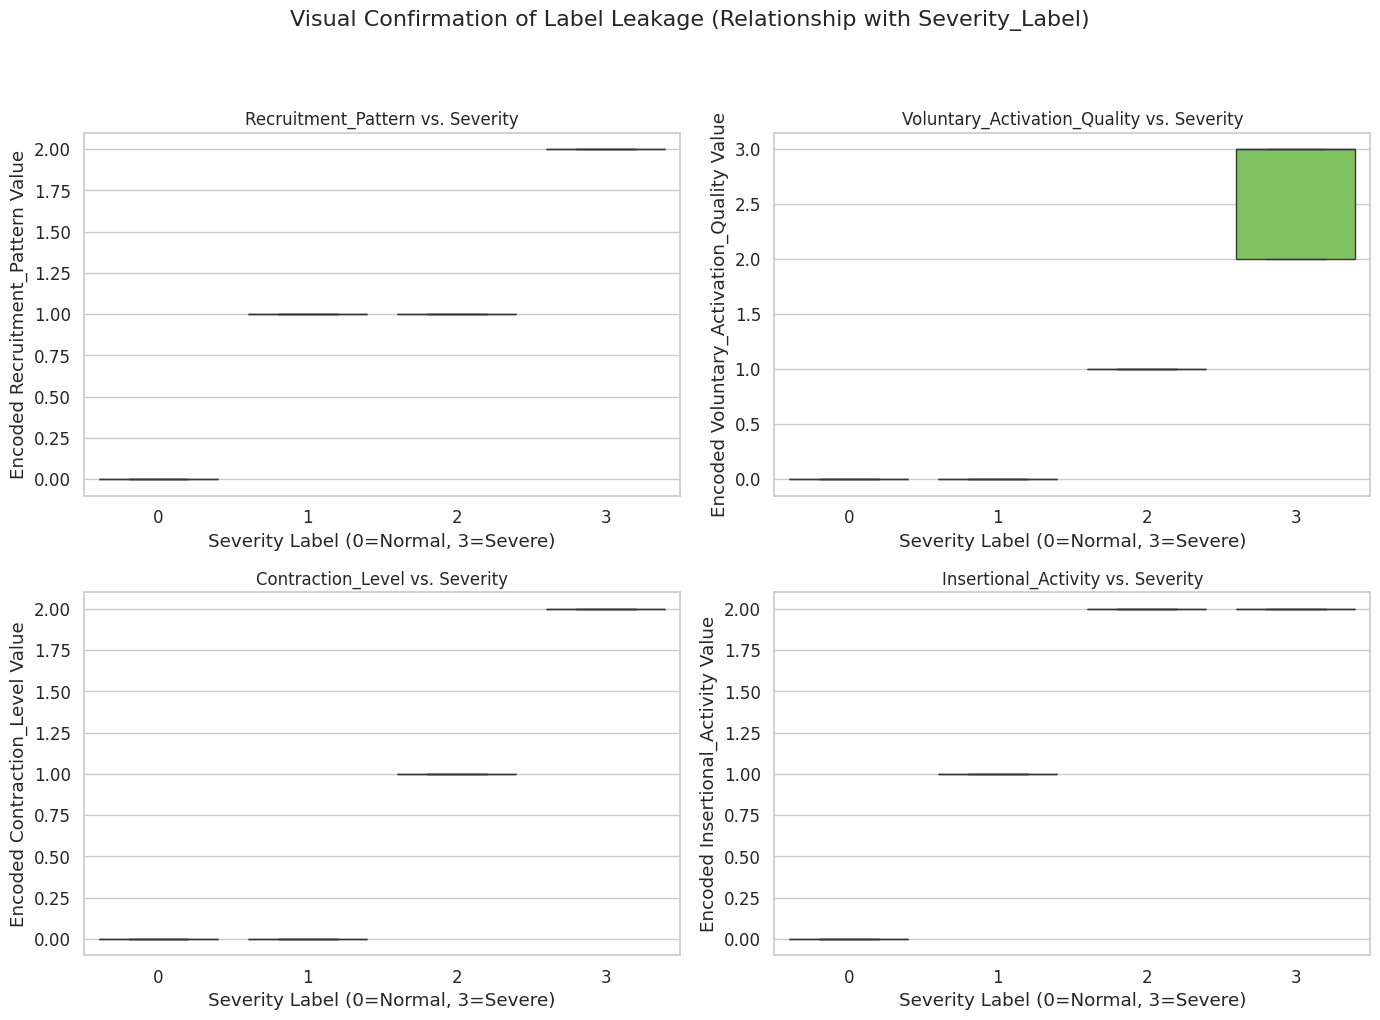

In [ ]:
# Potential leakage features to check
leakage_features = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

# Set up the figure for all four plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

fig.suptitle('Visual Confirmation of Label Leakage (Relationship with Severity_Label)', fontsize=16, y=1.02)

for i, col in enumerate(leakage_features):
    # Plotting the encoded feature values against the target severity
    sns.boxplot(
        x='Severity_Label',
        y=col,
        data=EMG_df,
        ax=axes[i],
        palette='viridis'
    )
    axes[i].set_title(f'{col} vs. Severity', fontsize=12)
    axes[i].set_xlabel('Severity Label (0=Normal, 3=Severe)')
    axes[i].set_ylabel(f'Encoded {col} Value')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
## REMOVING LEAKAGE FEATURES

leakage_cols_to_remove = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

# Create the new, clean DataFrame by dropping the identified columns
# Use a list comprehension and errors='ignore' to prevent errors if a column was already dropped
df_no_leakage_final = EMG_df.drop(
    columns=[col for col in leakage_cols_to_remove if col in EMG_df.columns],
    errors='ignore'
)
print("Leakage features removed. New DataFrame shape:", df_no_leakage_final.shape)


Leakage features removed. New DataFrame shape: (238, 23)


# cross validation with new clean dataset ( after drop the leakage features )

In [ ]:
## REDEFINING X and y

# X: Features (drop the target variable from the leakage-free DataFrame)
X_CLEAN = df_no_leakage_final.drop("Severity_Label", axis=1)

# y: Target variable
y_CLEAN = df_no_leakage_final["Severity_Label"]

print("\nFeature matrix (X_CLEAN) created with", X_CLEAN.shape[1], "features.")
print("Target vector (y_CLEAN) created.")


Feature matrix (X_CLEAN) created with 22 features.
Target vector (y_CLEAN) created.


# Try multiple k values ( number of features )

In [ ]:
# Use the leakage-free data
X = X_CLEAN.copy()
y = y_CLEAN.copy()

n_features = X.shape[1]
print("Number of CLEAN features:", n_features)

# Values of k to try
k_values = [None, 3, 5, 8, 10, 12, 15, 20]
print("k_values:", k_values)

Number of CLEAN features: 22
k_values: [None, 3, 5, 8, 10, 12, 15, 20]


In [ ]:
# Number of features after cleaning
n_features = X.shape[1]
print("Number of CLEAN features:", n_features)

# k-values to evaluate for different feature selection strategies
k_values = [None, 3, 5, 8, 10, 12, 15, 20]
print("k_values:", k_values)

# Custom Fisher Score implementation (filter-based feature ranking)
def fisher_score_custom(X_arr, y_arr):
    X_arr = np.asarray(X_arr, dtype=float)
    y_arr = np.asarray(y_arr)

    classes = np.unique(y_arr)
    n_samples, n_feats = X_arr.shape
    overall_mean = X_arr.mean(axis=0)

    numerator = np.zeros(n_feats)      # Between-class variance
    denominator = np.zeros(n_feats)    # Within-class variance

    for c in classes:
        idx = (y_arr == c)
        X_c = X_arr[idx]
        n_c = X_c.shape[0]
        if n_c == 0:
            continue

        mean_c = X_c.mean(axis=0)
        var_c  = X_c.var(axis=0)

        numerator   += n_c * (mean_c - overall_mean) ** 2
        denominator += n_c * var_c

    return numerator / (denominator + 1e-8)

# Best SVM hyperparameters (from GridSearchCV or manual tuning)
BEST_C = 1.0
BEST_GAMMA = "scale"

results = []               # Store evaluation metrics for each (method, k)
classes = np.sort(y.unique())

# Store confusion matrices for each method + k + fold
cm_per = {}

# Feature selection strategies to compare
methods = ["all", "fisher", "embedded_l1svm", "forward"]

# Loop through all k-values and selection strategies
for k in k_values:
    for method in methods:

        # Determine the valid (method, k) combinations
        if method == "all":
            # Baseline model: use all features (only valid for k=None or k >= total features)
            if not (k is None or k >= n_features):
                continue
            method_name = "All Features"
            k_display = "all"
            use_selection = False

        else:
            # Selection methods require a valid integer k
            if (k is None) or (k >= n_features):
                continue

            k_display = k
            method_name = {
                "fisher": "Fisher Score",
                "embedded_l1svm": "Embedded L1-SVM",
                "forward": "Forward Selection"
            }[method]

            use_selection = True

        print("\n" + "="*80)
        print(f"Method: {method_name} | k = {k_display}")

        # Stratified 5-Fold Cross Validation (preserves class distribution)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # TEST metrics per fold
        accuracies_   = []
        macro_f1s     = []
        mccs          = []
        ap_severe_list = []

        # TRAIN metrics (used for overfitting analysis)
        train_accuracies_ = []
        train_macro_f1s   = []
        train_mccs        = []

        selected_features_for_k = None
        cm_per[(method_name, k_display)] = {}

        # Perform 5-Fold CV
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

            # Split fold into train/test
            X_train = X.iloc[train_idx].copy()
            X_test  = X.iloc[test_idx].copy()
            y_train = y.iloc[train_idx]
            y_test  = y.iloc[test_idx]

            # Frequency Encoding applied on TRAIN only (prevents leakage)
            for col in freq_cols:
                freq = X_train[col].value_counts(normalize=True)
                X_train[col] = X_train[col].map(freq)
                X_test[col]  = X_test[col].map(freq).fillna(0)

            # ----------------------------
            # Feature Selection (per method)
            # ----------------------------
            if not use_selection:
                # Baseline: use all features
                X_train_fs = X_train
                X_test_fs  = X_test
                selected_features = X_train.columns

            else:
                if method == "fisher":
                    # Filter method: Fisher Score ranking
                    scores = fisher_score_custom(X_train.values, y_train.values)
                    idx = np.argsort(scores)[::-1][:k]
                    selected_features = X_train.columns[idx]

                elif method == "embedded_l1svm":
                    # Embedded method: L1-regularized Linear SVM
                    l1_svm = LinearSVC(
                        penalty='l1',
                        dual=False,
                        C=0.1,
                        class_weight='balanced',
                        max_iter=5000,
                        random_state=42
                    )
                    l1_svm.fit(X_train, y_train)

                    importances = np.mean(np.abs(l1_svm.coef_), axis=0)
                    idx = np.argsort(importances)[::-1][:k]
                    selected_features = X_train.columns[idx]

                elif method == "forward":
                    # Wrapper method: Sequential Forward Selection (SVM RBF)
                    base_svm = Pipeline([
                        ("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler()),
                        ("svm", SVC(
                            kernel='rbf',
                            C=BEST_C,
                            gamma=BEST_GAMMA,
                            class_weight='balanced'
                        ))
                    ])

                    sfs = SequentialFeatureSelector(
                        base_svm,
                        n_features_to_select=k,
                        direction='forward',
                        cv=3,
                        n_jobs=-1
                    )
                    sfs.fit(X_train, y_train)
                    mask = sfs.get_support()
                    selected_features = X_train.columns[mask]

                # Apply selected feature subset
                X_train_fs = X_train[selected_features]
                X_test_fs  = X_test[selected_features]

            # Save selected features once per (method, k)
            if selected_features_for_k is None:
                selected_features_for_k = list(selected_features)

            # ----------------------------
            # Final SVM RBF model for evaluation
            # ----------------------------
            model = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
                ("svm", SVC(
                    kernel='rbf',
                    C=BEST_C,
                    gamma=BEST_GAMMA,
                    class_weight='balanced',
                    probability=True
                ))
            ])

            # TRAIN performance
            model.fit(X_train_fs, y_train)
            y_train_pred = model.predict(X_train_fs)

            train_acc      = accuracy_score(y_train, y_train_pred)
            train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
            train_mcc      = matthews_corrcoef(y_train, y_train_pred)

            train_accuracies_.append(train_acc)
            train_macro_f1s.append(train_macro_f1)
            train_mccs.append(train_mcc)

            # TEST performance
            y_pred  = model.predict(X_test_fs)
            y_proba = model.predict_proba(X_test_fs)

            acc      = accuracy_score(y_test, y_pred)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            mcc      = matthews_corrcoef(y_test, y_pred)

            # AP for the Severe class (AUC-PR metric)
            y_test_severe = (y_test == severe_label).astype(int)
            severe_index  = np.where(model.named_steps["svm"].classes_ == severe_label)[0][0]
            severe_probs  = y_proba[:, severe_index]
            ap_severe     = average_precision_score(y_test_severe, severe_probs)

            accuracies_.append(acc)
            macro_f1s.append(macro_f1)
            mccs.append(mcc)
            ap_severe_list.append(ap_severe)

            # Confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred, labels=classes)
            cm_per[(method_name, k_display)][fold] = cm

            print(
                f"Fold {fold} - "
                f"Train Acc: {train_acc:.3f}, Test Acc: {acc:.3f}, "
                f"Train Macro F1: {train_macro_f1:.3f}, Test Macro F1: {macro_f1:.3f}, "
                f"Train MCC: {train_mcc:.3f}, Test MCC: {mcc:.3f}, "
                f"AP_severe (test): {ap_severe:.3f}"
            )

        # Aggregate performance across folds for this (method, k)
        result_row = {
            "method": method_name,
            "k": k_display,

            # TEST statistics
            "mean_accuracy":   np.mean(accuracies_),
            "mean_macro_f1":   np.mean(macro_f1s),
            "mean_MCC":        np.mean(mccs),
            "mean_AP_severe":  np.mean(ap_severe_list),

            # TRAIN statistics
            "train_mean_accuracy": np.mean(train_accuracies_),
            "train_mean_macro_f1": np.mean(train_macro_f1s),
            "train_mean_MCC":      np.mean(train_mccs),

            "selected_features": selected_features_for_k
        }

        results.append(result_row)

# Display summary of all methods and k-values
results_df = pd.DataFrame(results)
print("\n\n=== All results (methods comparison) ===")
print(results_df)


Number of CLEAN features: 22
k_values: [None, 3, 5, 8, 10, 12, 15, 20]

Method: All Features | k = all
Fold 1 - Train Acc: 0.974, Test Acc: 0.875, Train Macro F1: 0.968, Test Macro F1: 0.855, Train MCC: 0.963, Test MCC: 0.833, AP_severe (test): 0.943
Fold 2 - Train Acc: 0.968, Test Acc: 0.917, Train Macro F1: 0.963, Test Macro F1: 0.888, Train MCC: 0.956, Test MCC: 0.883, AP_severe (test): 0.851
Fold 3 - Train Acc: 0.974, Test Acc: 0.833, Train Macro F1: 0.971, Test Macro F1: 0.729, Train MCC: 0.963, Test MCC: 0.761, AP_severe (test): 0.367
Fold 4 - Train Acc: 0.979, Test Acc: 0.915, Train Macro F1: 0.976, Test Macro F1: 0.851, Train MCC: 0.971, Test MCC: 0.878, AP_severe (test): 0.528
Fold 5 - Train Acc: 0.979, Test Acc: 0.872, Train Macro F1: 0.972, Test Macro F1: 0.827, Train MCC: 0.970, Test MCC: 0.822, AP_severe (test): 0.786

Method: Fisher Score | k = 3
Fold 1 - Train Acc: 0.900, Test Acc: 0.917, Train Macro F1: 0.875, Test Macro F1: 0.919, Train MCC: 0.865, Test MCC: 0.892, AP_

In [ ]:
# Display the selected feature subset for each (method, k) combination
for row in results:
    print("\n### Method:", row["method"], "| k =", row["k"], "###")
    print("Selected Features:")

    sf = row["selected_features"]
    if isinstance(sf, list):
        for f in sf:
            print(" -", f)
    else:
        print(sf)


### Method: All Features | k = all ###
Selected Features:
 - age
 - sex
 - BMI
 - dominant_side
 - affected_limb
 - limb_temperature_c
 - affected_limb_dominance
 - injury_type
 - time_since_injury_months
 - muscle_name
 - side
 - Electrode_Type
 - Electrode_Depth
 - Positive_Sharp_Waves
 - Fibrillation
 - Fasciculation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)
 - Polyphasic_Units
 - limb_temperature_c_missing
 - time_since_injury_months_missing
 - Electrode_Depth_missing

### Method: Fisher Score | k = 3 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves

### Method: Embedded L1-SVM | k = 3 ###
Selected Features:
 - Fasciculation
 - time_since_injury_months
 - MUAP_Amplitude (mV)

### Method: Forward Selection | k = 3 ###
Selected Features:
 - injury_type
 - Fasciculation
 - time_since_injury_months_missing

### Method: Fisher Score | k = 5 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_A

# Plotting confusion matrix for each fold

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    cm: 2D numpy array (confusion matrix)
    class_names: list of class labels to show on axes
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    # show matrix as image (no grid lines)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    ax.grid(False)

    # colorbar on the right
    cbar = ax.figure.colorbar(im, ax=ax)

    # ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    # rotate x labels a bit
    plt.setp(
        ax.get_xticklabels(),
        rotation=45, ha="right", rotation_mode="anchor"
    )

    # write the numbers
    max_val = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            text_color = "white" if value > max_val / 2 else "black"
            ax.text(
                j, i, format(value, "d"),
                ha="center", va="center", color=text_color
            )

    fig.tight_layout()
    plt.show()



====== Fisher Score: k = 3 ======



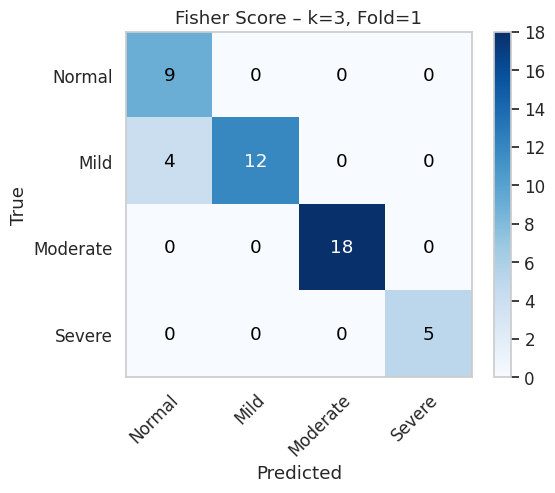

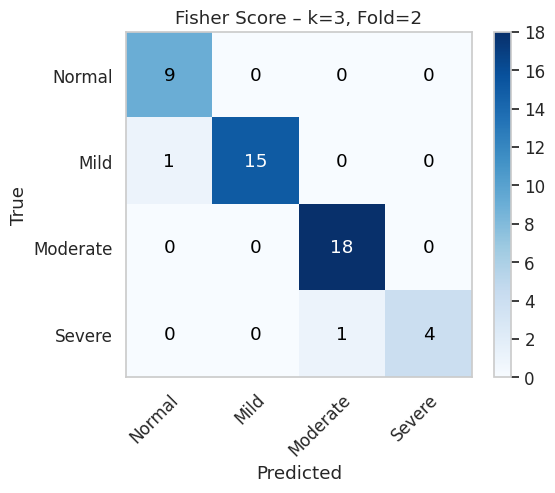

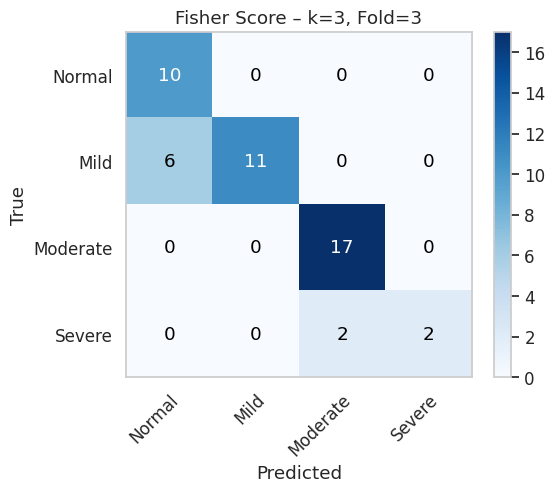

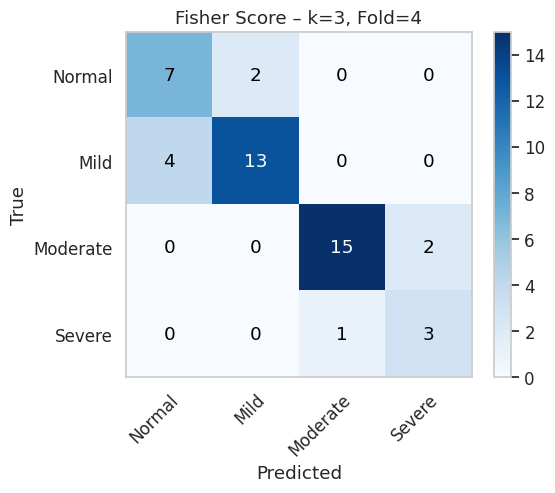

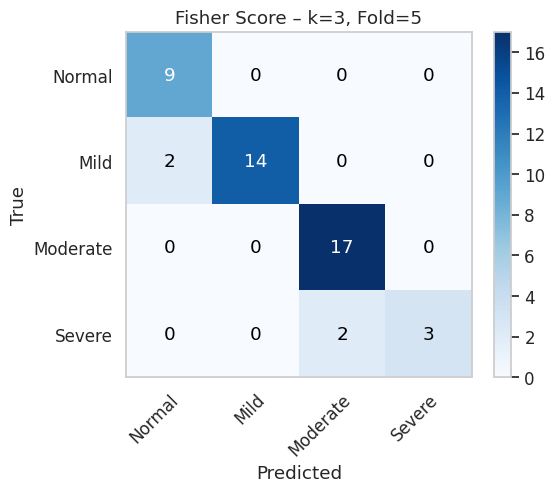


====== Fisher Score: k = 5 ======



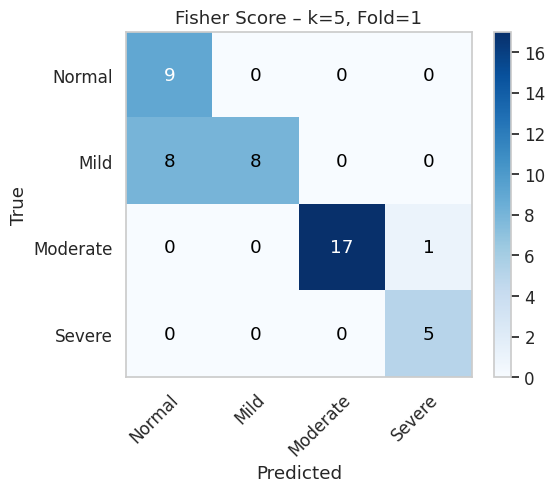

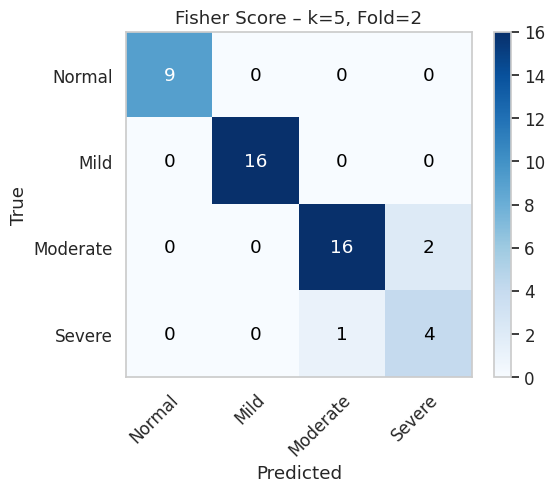

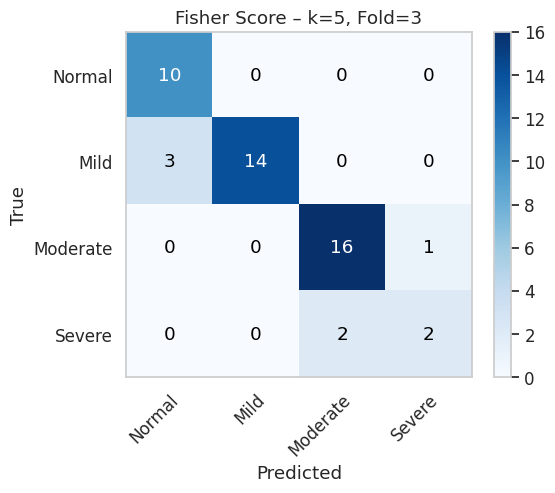

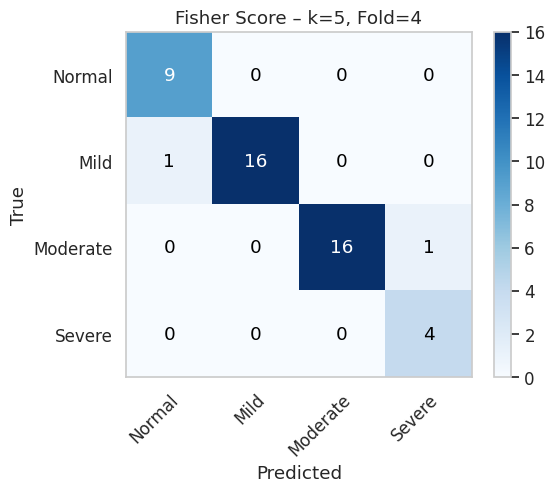

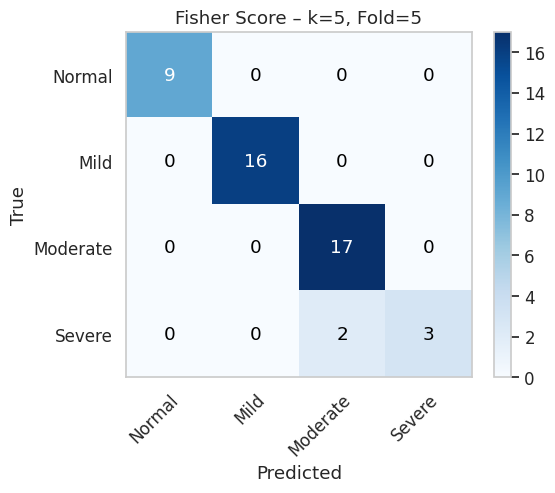


====== Fisher Score: k = 8 ======



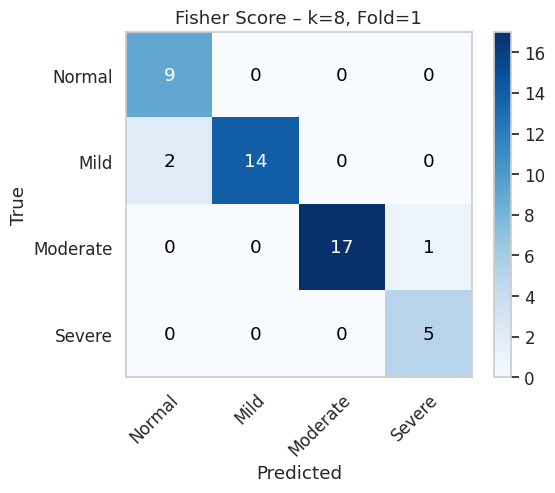

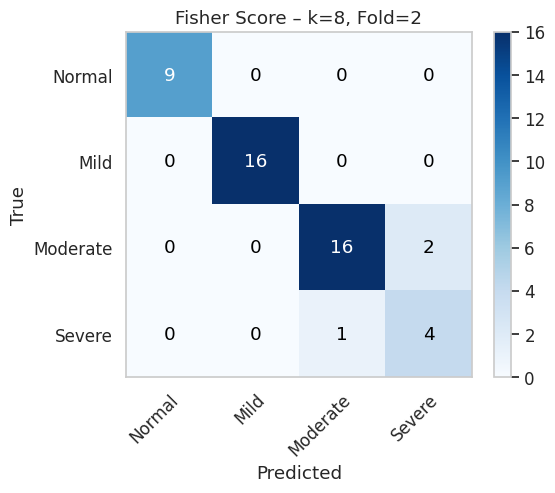

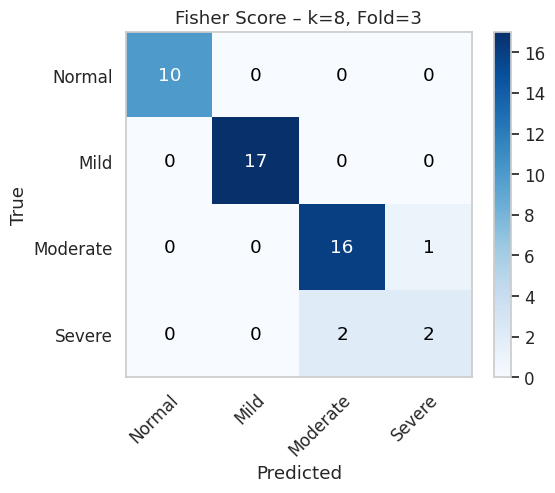

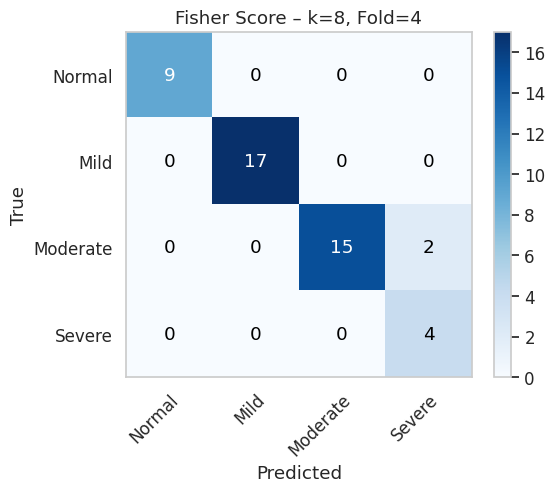

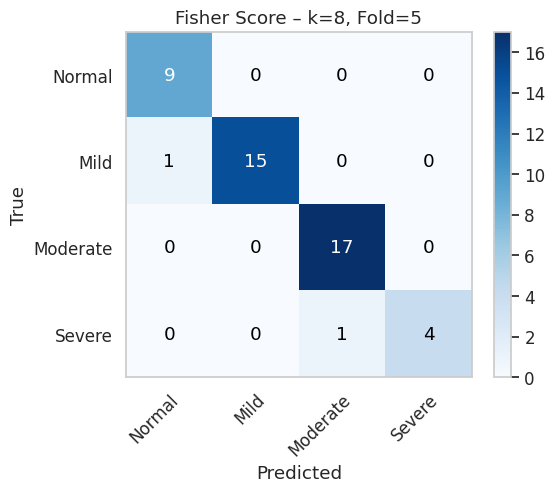


====== Fisher Score: k = 10 ======



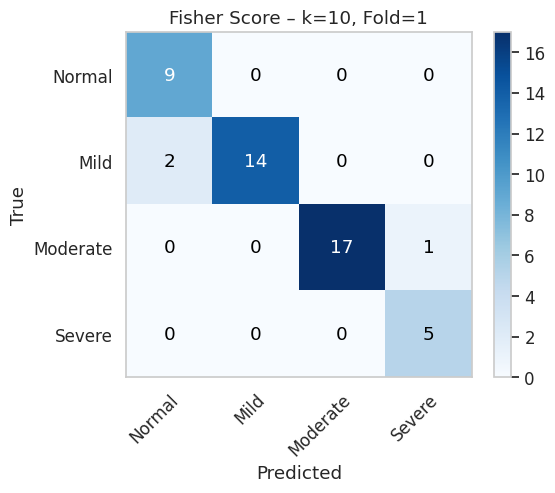

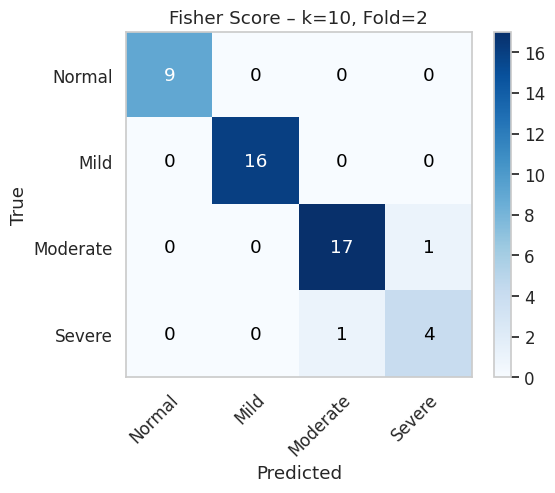

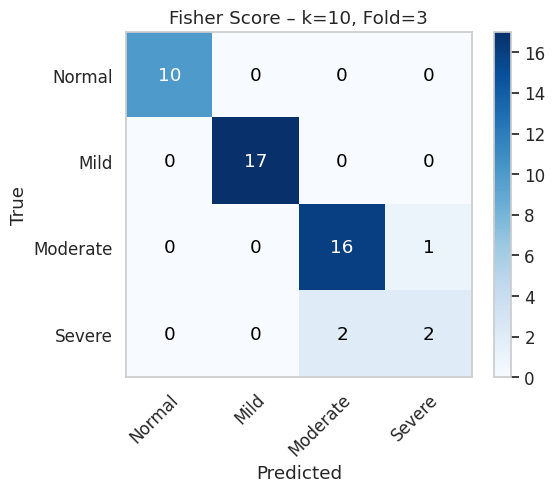

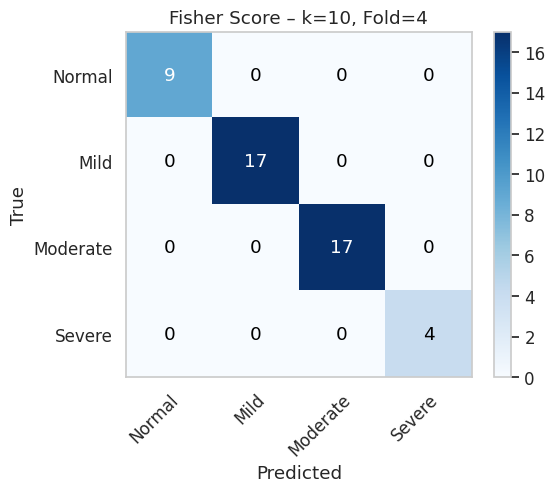

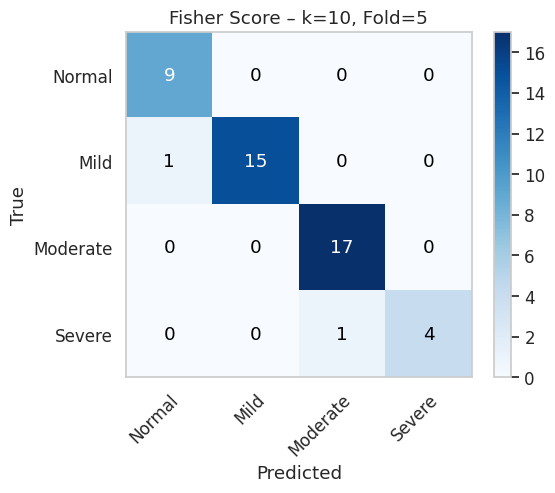


====== Fisher Score: k = 12 ======



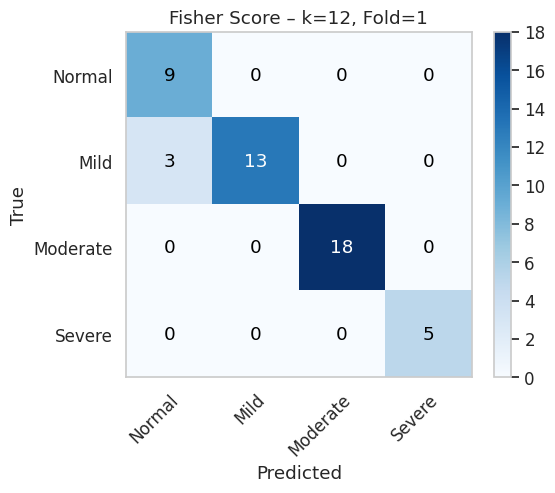

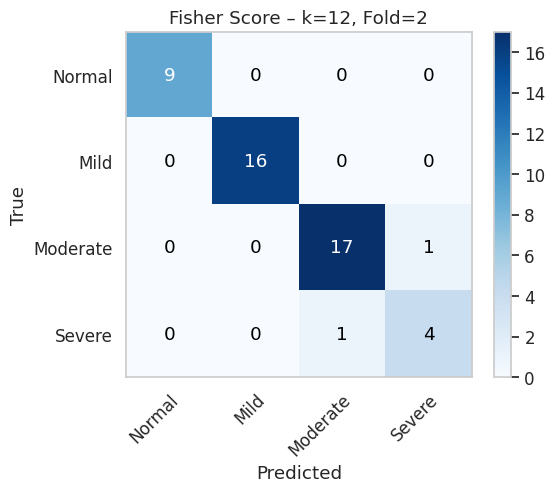

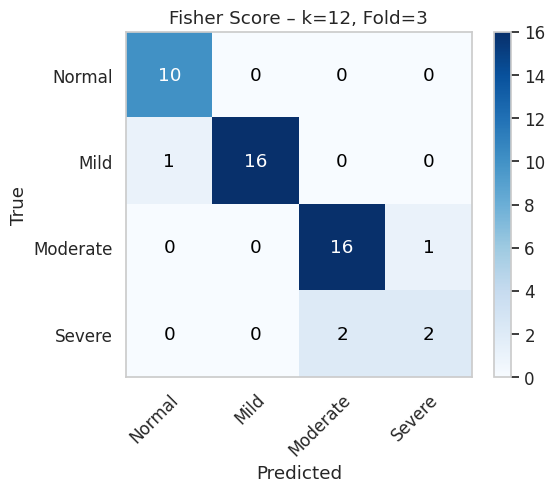

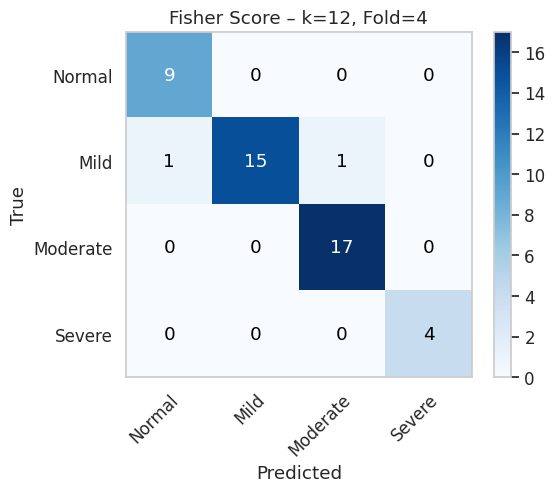

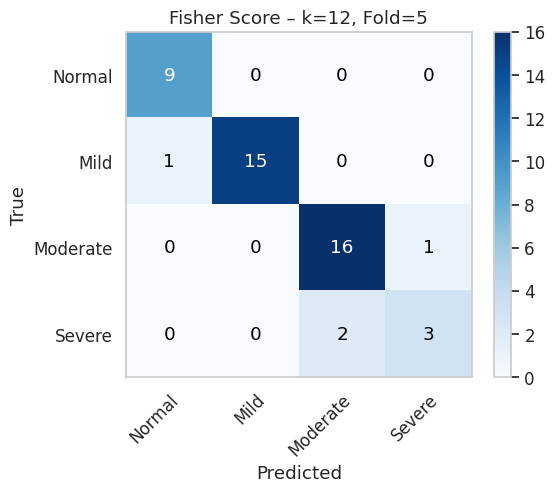


====== Fisher Score: k = 15 ======



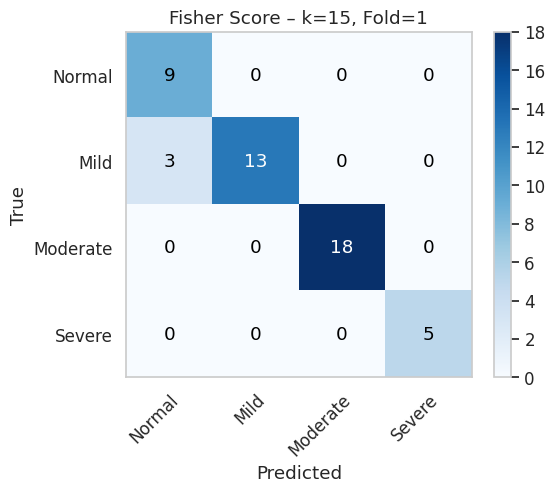

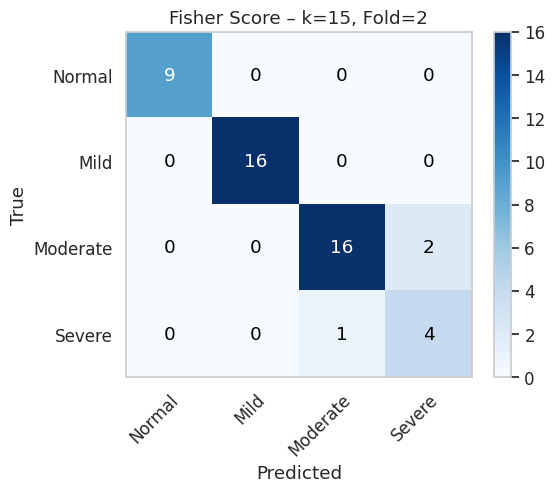

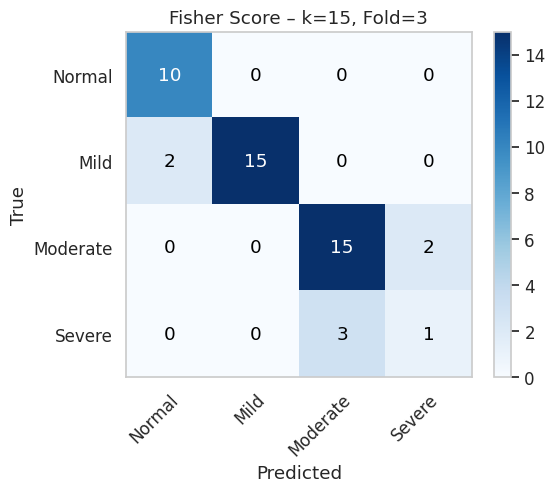

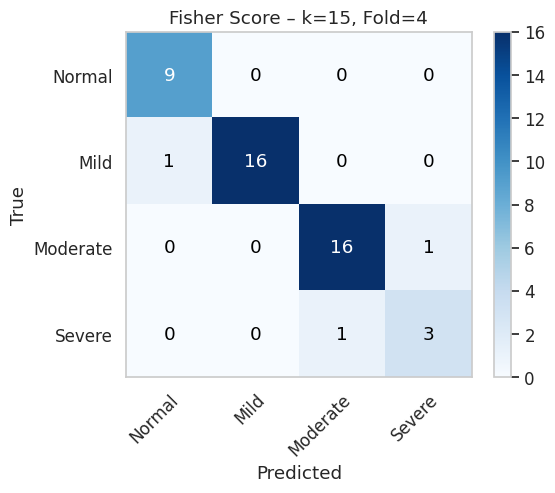

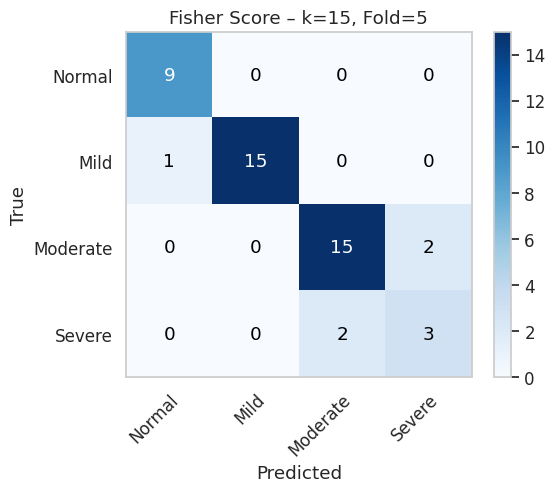


====== Fisher Score: k = 20 ======



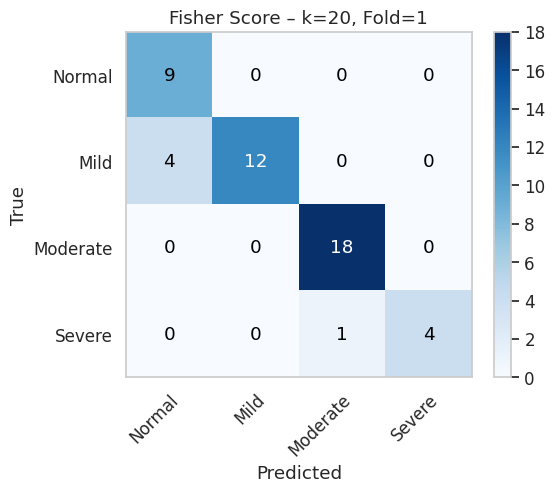

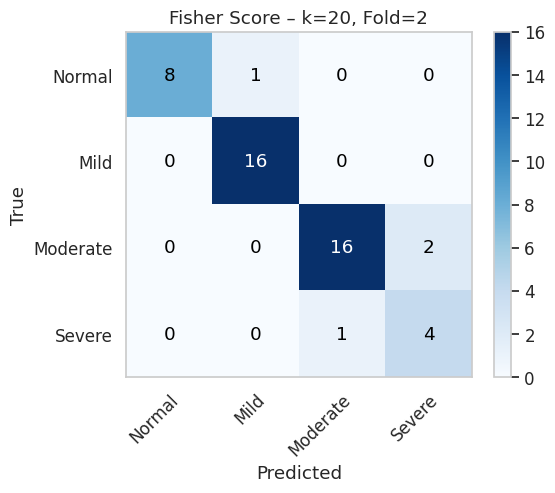

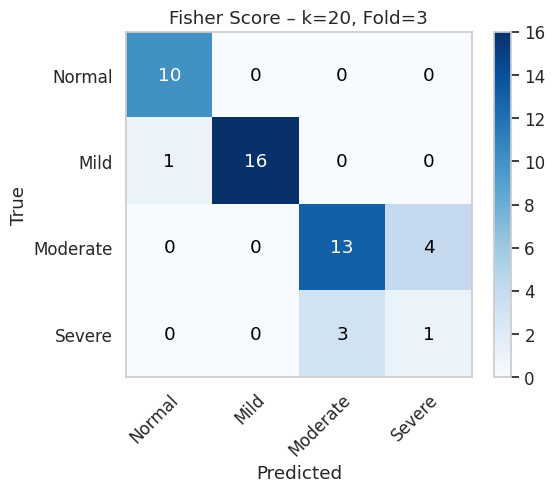

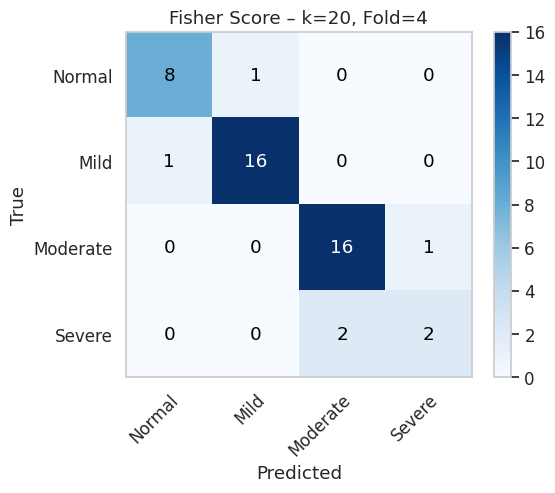

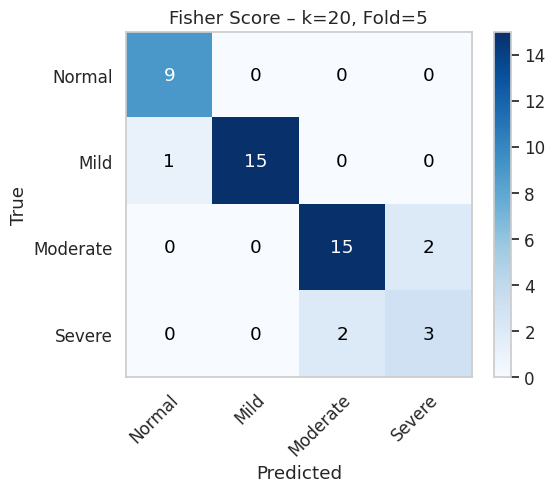

In [ ]:
# Plot confusion matrices for Fisher Score feature selection across all folds
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for (method_name, k_display), folds_dict in cm_per.items():
    if method_name != "Fisher Score":
        continue  # Only visualize Fisher Score results

    print(f"\n====== Fisher Score: k = {k_display} ======\n")

    for fold, cm in folds_dict.items():
        plot_confusion_matrix(
            cm,
            class_names=class_names,
            title=f"Fisher Score – k={k_display}, Fold={fold}"
        )


# Aggregated (overall) confusion matrix

In [ ]:
def get_aggregated_confusion_matrix(cm_dict_for_k):
    """
    cm_dict_for_k = cm_per_k_fold[k_display]
    returns the sum of all fold confusion matrices
    """
    cms = list(cm_dict_for_k.values())       # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)                # element-wise sum
    return agg


Fisher rows found:
           method   k
1   Fisher Score   3
4   Fisher Score   5
7   Fisher Score   8
10  Fisher Score  10
13  Fisher Score  12
16  Fisher Score  15
19  Fisher Score  20 


Plotting Fisher Score aggregated confusion matrix for k = 3


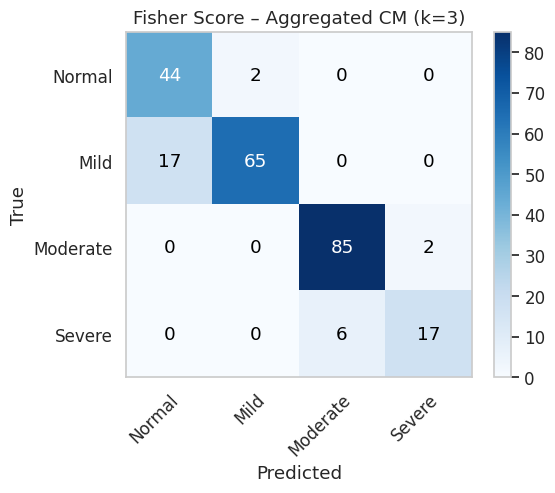


Plotting Fisher Score aggregated confusion matrix for k = 5


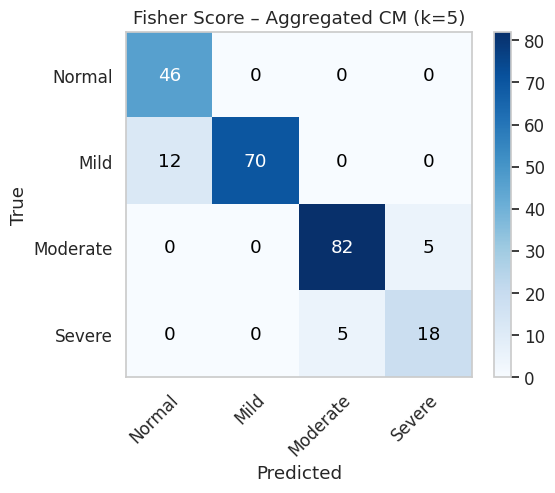


Plotting Fisher Score aggregated confusion matrix for k = 8


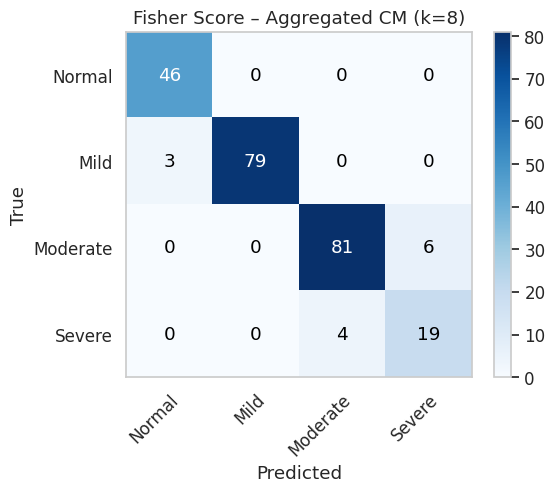


Plotting Fisher Score aggregated confusion matrix for k = 10


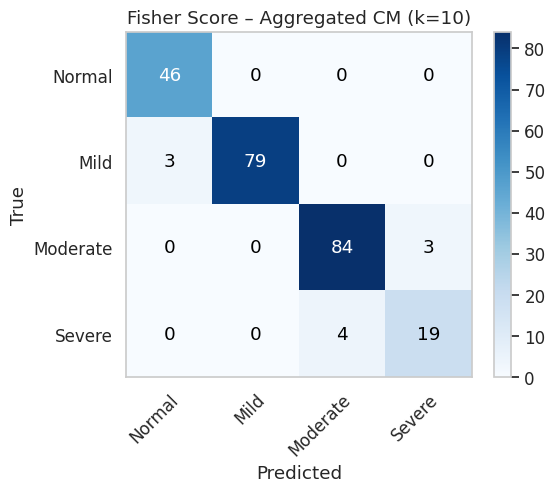


Plotting Fisher Score aggregated confusion matrix for k = 12


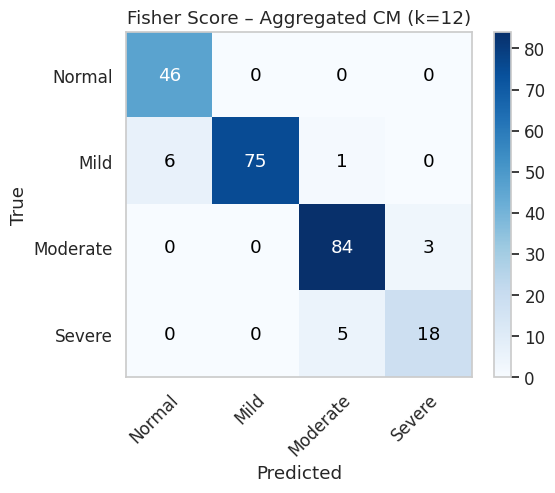


Plotting Fisher Score aggregated confusion matrix for k = 15


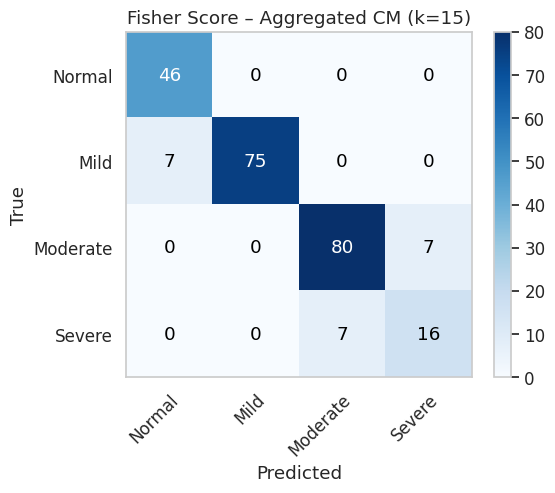


Plotting Fisher Score aggregated confusion matrix for k = 20


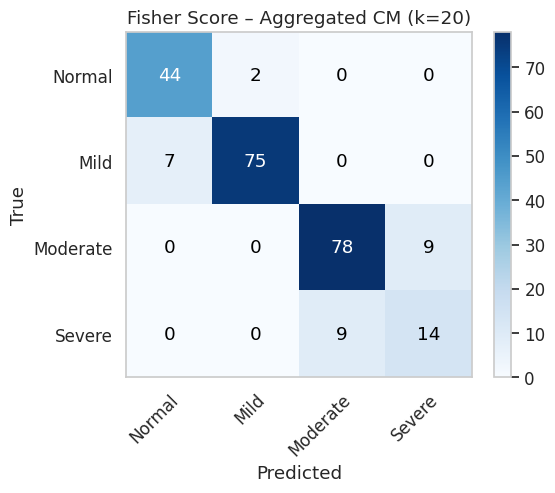

In [ ]:
# Plot aggregated CM for ALL Fisher Score k values

class_names = ["Normal", "Mild", "Moderate", "Severe"]

# Filter results_df to only keep Fisher Score rows
fisher_rows = results_df[results_df["method"] == "Fisher Score"]

print("Fisher rows found:\n", fisher_rows[["method", "k"]], "\n")

for idx, row in fisher_rows.iterrows():

    method_name = row["method"]        # "Fisher Score"
    k_display   = row["k"]             # 3, 5, 8, 10, 12, ...

    print(f"\n===========================================================")
    print(f"Plotting Fisher Score aggregated confusion matrix for k = {k_display}")
    print("==============================================================")

    # Get all 5 fold confusion matrices
    cm_dict_for_k = cm_per[(method_name, k_display)]

    # Aggregate (sum)
    cm_overall = get_aggregated_confusion_matrix(cm_dict_for_k)

    # Plot
    plot_confusion_matrix(
        cm_overall,
        class_names,
        title=f"Fisher Score – Aggregated CM (k={k_display})"
    )



# overfitting cheking

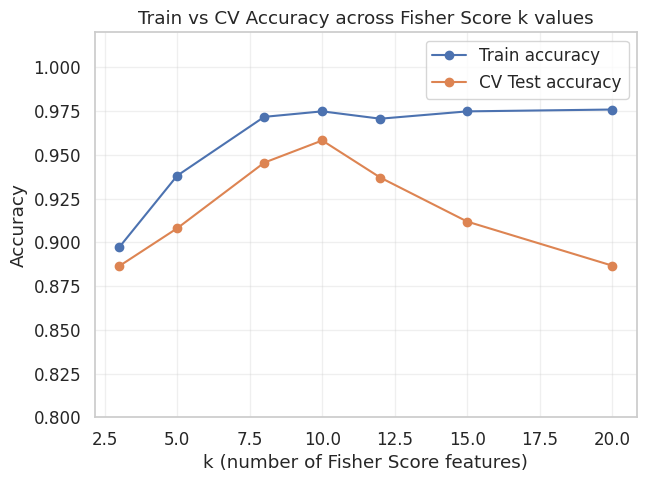

In [ ]:
# Filter only Fisher Score rows
fisher_df = results_df[results_df["method"] == "Fisher Score"].copy()

# Ensure k is numeric (not 'all')
fisher_df = fisher_df[fisher_df["k"] != "all"]

x_labels = fisher_df["k"].astype(int)

plt.figure(figsize=(7,5))
plt.plot(x_labels, fisher_df["train_mean_accuracy"], marker="o", label="Train accuracy")
plt.plot(x_labels, fisher_df["mean_accuracy"], marker="o", label="CV Test accuracy")

plt.xlabel("k (number of Fisher Score features)")
plt.ylabel("Accuracy")
plt.title("Train vs CV Accuracy across Fisher Score k values")
plt.ylim(0.8, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



# **------------------- Model Implementation with 8 features ---------------------**

In [ ]:
# Final Fisher Score features for k = 8
final_features = [
    "Fasciculation",
    "Polyphasic_Units",
    "Positive_Sharp_Waves",
    "Fibrillation",
    "MUAP_Amplitude (mV)",
    "MUAP_Duration (ms)",
    "time_since_injury_months",
    "injury_type"
]

# Use only the selected Fisher features
X_final = X[final_features].copy()

# Keep only frequency-encoded columns that exist in X_final
freq_cols_final = [c for c in freq_cols if c in X_final.columns]

print("Final X shape:", X_final.shape)
print("Final features:", list(X_final.columns))
print("Frequency-encoded columns in final model:", freq_cols_final)

Final X shape: (238, 8)
Final features: ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']
Frequency-encoded columns in final model: ['injury_type']


In [ ]:
# ========================
# Lists for TEST metrics
# ========================
accuracies        = []
macro_f1s         = []
macro_precisions  = []
macro_recalls     = []
mccs              = []
ap_severe_ls      = []

# ========================
# Lists for TRAIN metrics
# ========================
train_accuracies  = []
train_macro_f1s   = []
train_mccs        = []

# Store confusion matrices per fold (TEST)
cm_per_fold = {}

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ----- Frequency Encoding (TRAIN only, apply mapping to TEST) -----
    for col in freq_cols_final:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col]  = X_test[col].map(freq).fillna(0)

    # ----- SVM RBF Model (Pipeline) -----
    svm_model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("svm", SVC(
            kernel="rbf",
            C=1.0,
            gamma="scale",
            class_weight="balanced",
            probability=True
        ))
    ])

    svm_model.fit(X_train, y_train)

    # ===== TRAIN predictions & metrics =====
    y_pred_train = svm_model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_pred_train)
    train_macro_f1 = f1_score(y_train, y_pred_train, average='macro')
    train_mcc      = matthews_corrcoef(y_train, y_pred_train)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_mccs.append(train_mcc)

    # ===== TEST predictions & metrics =====
    y_pred  = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)

    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    mcc      = matthews_corrcoef(y_test, y_pred)

    macro_precision = precision_score(
        y_test, y_pred, average='macro', zero_division=0
    )
    macro_recall    = recall_score(
        y_test, y_pred, average='macro', zero_division=0
    )

    # AUC-PR for Severe class (TEST)
    y_test_severe = (y_test == severe_label).astype(int)

    svm_classes  = svm_model.named_steps["svm"].classes_
    severe_index = np.where(svm_classes == severe_label)[0][0]
    severe_probs = y_proba[:, severe_index]

    ap_severe = average_precision_score(y_test_severe, severe_probs)

    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    mccs.append(mcc)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix (TEST)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    # ===== Fold summary (same style as RF code) =====
    print(
        f"Fold {fold} - "
        f"Train Acc: {train_acc:.3f}, "
        f"Test Acc: {acc:.3f}, "
        f"Train F1: {train_macro_f1:.3f}, "
        f"Test F1: {macro_f1:.3f}, "
        f"Train MCC: {train_mcc:.3f}, "
        f"Test MCC: {mcc:.3f}, "
        f"AP_severe (test): {ap_severe:.3f}"
    )

# ===== Final averaged metrics =====
print("\n===== FINAL 5-fold CV (SVM RBF, Fisher k=8) =====")
print("Mean Train Accuracy: ", np.mean(train_accuracies))
print("Mean Test  Accuracy: ", np.mean(accuracies))
print("Mean Train Macro F1: ", np.mean(train_macro_f1s))
print("Mean Test  Macro F1: ", np.mean(macro_f1s))
print("Mean Train MCC:      ", np.mean(train_mccs))
print("Mean Test  MCC:      ", np.mean(mccs))
print("Mean Test Precision: ", np.mean(macro_precisions))
print("Mean Test Recall:    ", np.mean(macro_recalls))
print("Mean Test AP_severe: ", np.mean(ap_severe_ls))


Fold 1 - Train Acc: 0.974, Test Acc: 0.938, Train F1: 0.960, Test F1: 0.928, Train MCC: 0.963, Test MCC: 0.915, AP_severe (test): 0.927
Fold 2 - Train Acc: 0.974, Test Acc: 0.938, Train F1: 0.966, Test F1: 0.910, Train MCC: 0.963, Test MCC: 0.912, AP_severe (test): 0.837
Fold 3 - Train Acc: 0.979, Test Acc: 0.938, Train F1: 0.976, Test F1: 0.871, Train MCC: 0.971, Test MCC: 0.910, AP_severe (test): 0.560
Fold 4 - Train Acc: 0.963, Test Acc: 0.957, Train F1: 0.951, Test F1: 0.934, Train MCC: 0.948, Test MCC: 0.942, AP_severe (test): 1.000
Fold 5 - Train Acc: 0.969, Test Acc: 0.957, Train F1: 0.955, Test F1: 0.944, Train MCC: 0.955, Test MCC: 0.941, AP_severe (test): 0.967

===== FINAL 5-fold CV (SVM RBF, Fisher k=8) =====
Mean Train Accuracy:  0.9716505924497107
Mean Test  Accuracy:  0.9454787234042554
Mean Train Macro F1:  0.9614676214604669
Mean Test  Macro F1:  0.9177026678989751
Mean Train MCC:       0.959933204409668
Mean Test  MCC:       0.9242007070946668
Mean Test Precision:  0.

In [ ]:
# ==========================================
#  AGGREGATED CONFUSION MATRIX (SVM RBF, Fisher k=8)
# ==========================================
def get_aggregated_confusion_matrix(cm_dict):
    """
    cm_dict: dictionary {fold_id: confusion_matrix}
    returns: element-wise sum of all confusion matrices
    """
    cms = list(cm_dict.values())
    agg = np.sum(cms, axis=0)
    return agg

# Sum confusion matrices over all folds (TEST)
cm_overall = get_aggregated_confusion_matrix(cm_per_fold)

print("\n=== Aggregated Confusion Matrix over 5 folds (TEST) ===")
print(cm_overall)

# ==========================================
#   PER-CLASS METRICS (from aggregated CM)
# ==========================================
print("\n===== Per-Class Metrics (from aggregated confusion matrix) =====\n")

for i, cls in enumerate(classes):
    TP = cm_overall[i, i]
    FN = cm_overall[i, :].sum() - TP
    FP = cm_overall[:, i].sum() - TP
    TN = cm_overall.sum() - (TP + FN + FP)

    # One-vs-rest accuracy for this class
    acc = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    # Precision, Recall, F1 for this class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class: {cls}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-score:  {f1:.4f}\n")



=== Aggregated Confusion Matrix over 5 folds (TEST) ===
[[46  0  0  0]
 [ 3 79  0  0]
 [ 0  0 81  6]
 [ 0  0  4 19]]

===== Per-Class Metrics (from aggregated confusion matrix) =====

Class: 0
   Accuracy:  0.9874
   Precision: 0.9388
   Recall:    1.0000
   F1-score:  0.9684

Class: 1
   Accuracy:  0.9874
   Precision: 1.0000
   Recall:    0.9634
   F1-score:  0.9814

Class: 2
   Accuracy:  0.9580
   Precision: 0.9529
   Recall:    0.9310
   F1-score:  0.9419

Class: 3
   Accuracy:  0.9580
   Precision: 0.7600
   Recall:    0.8261
   F1-score:  0.7917



# **hyperparameter tuning for SVM with k = 8**

In [ ]:
# Working on the 8 Fisher features
X_tune = X_final.copy()
y_tune = y.copy()

param_grid_svm = {
    "C":     [0.1, 1, 5, 10, 20],
    "gamma": ["scale", 0.01, 0.05, 0.1, 1]
}

keys = list(param_grid_svm.keys())
param_combos = list(product(*param_grid_svm.values()))
print("Total SVM combinations:", len(param_combos))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuning_rows_svm = []

for combo in param_combos:
    params = dict(zip(keys, combo))
    print("\nTesting params:", params)

    fold_macro_f1 = []
    fold_ap_severe = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tune, y_tune), start=1):

        X_train = X_tune.iloc[train_idx].copy()
        X_test  = X_tune.iloc[test_idx].copy()
        y_train = y_tune.iloc[train_idx]
        y_test  = y_tune.iloc[test_idx]

        # Frequency encoding
        for col in freq_cols_final:
            freq = X_train[col].value_counts(normalize=True)
            X_train[col] = X_train[col].map(freq)
            X_test[col]  = X_test[col].map(freq).fillna(0)

        # SVM pipeline
        model_svm = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("svm", SVC(
                kernel="rbf",
                C=params["C"],
                gamma=params["gamma"],
                class_weight="balanced",
                probability=True
            ))
        ])

        model_svm.fit(X_train, y_train)

        # predictions
        y_pred  = model_svm.predict(X_test)
        y_proba = model_svm.predict_proba(X_test)

        macro_f1 = f1_score(y_test, y_pred, average='macro')

        # severe AP
        y_test_severe = (y_test == severe_label).astype(int)
        svm_classes = model_svm.named_steps["svm"].classes_
        severe_index = np.where(svm_classes == severe_label)[0][0]
        severe_probs = y_proba[:, severe_index]
        ap_severe = average_precision_score(y_test_severe, severe_probs)

        fold_macro_f1.append(macro_f1)
        fold_ap_severe.append(ap_severe)

    row = {
        "C": params["C"],
        "gamma": params["gamma"],
        "mean_macro_f1": np.mean(fold_macro_f1),
        "mean_AP_severe": np.mean(fold_ap_severe),
    }
    tuning_rows_svm.append(row)

    print(" → mean_macro_f1 = %.4f | mean_AP_severe = %.4f"
          % (row["mean_macro_f1"], row["mean_AP_severe"]))

# dataframe
tuning_svm_df = pd.DataFrame(tuning_rows_svm)
tuning_svm_df = tuning_svm_df.sort_values(by="mean_macro_f1", ascending=False)

print("\n=== Top SVM RBF Hyperparameters ===")
print(tuning_svm_df.head(10))


Total SVM combinations: 25

Testing params: {'C': 0.1, 'gamma': 'scale'}
 → mean_macro_f1 = 0.8731 | mean_AP_severe = 0.8256

Testing params: {'C': 0.1, 'gamma': 0.01}
 → mean_macro_f1 = 0.3428 | mean_AP_severe = 0.2366

Testing params: {'C': 0.1, 'gamma': 0.05}
 → mean_macro_f1 = 0.8417 | mean_AP_severe = 0.7917

Testing params: {'C': 0.1, 'gamma': 0.1}
 → mean_macro_f1 = 0.8731 | mean_AP_severe = 0.8256

Testing params: {'C': 0.1, 'gamma': 1}
 → mean_macro_f1 = 0.3623 | mean_AP_severe = 0.0986

Testing params: {'C': 1, 'gamma': 'scale'}
 → mean_macro_f1 = 0.9177 | mean_AP_severe = 0.8594

Testing params: {'C': 1, 'gamma': 0.01}
 → mean_macro_f1 = 0.8754 | mean_AP_severe = 0.8077

Testing params: {'C': 1, 'gamma': 0.05}
 → mean_macro_f1 = 0.9248 | mean_AP_severe = 0.9025

Testing params: {'C': 1, 'gamma': 0.1}
 → mean_macro_f1 = 0.9228 | mean_AP_severe = 0.8688

Testing params: {'C': 1, 'gamma': 1}
 → mean_macro_f1 = 0.6879 | mean_AP_severe = 0.6495

Testing params: {'C': 5, 'gamma': 

In [ ]:
# ================================
#  Tuned SVM-RBF (Fisher k = 8)
# ================================

# from previous tuning
best_C     = 20
best_gamma = "scale"

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists for TEST metrics
accuracies        = []
macro_f1s         = []
macro_precisions  = []
macro_recalls     = []
mccs              = []
ap_severe_ls      = []

# Lists for TRAIN metrics (for overfitting check)
train_accuracies    = []
train_macro_f1s     = []
train_macro_precs   = []
train_macro_recalls = []
train_mccs          = []

cm_per_fold = {}   # to store confusion matrices per fold (TEST)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ----- Frequency Encoding -----
    for col in freq_cols_final:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col]  = X_test[col].map(freq).fillna(0)

    # ----------- Tuned SVM Model -----------
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("svm", SVC(
            kernel='rbf',
            C=best_C,
            gamma=best_gamma,
            class_weight='balanced',
            probability=True
        ))
    ])

    model.fit(X_train, y_train)

    # ============ TRAIN predictions ============
    y_train_pred = model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_train_pred)
    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_macro_p  = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_macro_r  = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_mcc      = matthews_corrcoef(y_train, y_train_pred)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_macro_precs.append(train_macro_p)
    train_macro_recalls.append(train_macro_r)
    train_mccs.append(train_mcc)

    # ============ TEST predictions ============
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
    mcc      = matthews_corrcoef(y_test, y_pred)

    # Severe AP (AUC-PR for severe class)
    y_test_severe = (y_test == severe_label).astype(int)

    svm_step     = model.named_steps["svm"]
    severe_index = np.where(svm_step.classes_ == severe_label)[0][0]

    severe_probs = y_proba[:, severe_index]
    ap_severe    = average_precision_score(y_test_severe, severe_probs)

    # Save TEST metrics
    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    mccs.append(mcc)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix (TEST) – same labels as RF
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    print(
        f"Fold {fold} - "
        f"Train Acc: {train_acc:.3f}, Test Acc: {acc:.3f}, "
        f"Train F1: {train_macro_f1:.3f}, Test F1: {macro_f1:.3f}, "
        f"Train MCC: {train_mcc:.3f}, Test MCC: {mcc:.3f}, "
        f"AP_severe (test): {ap_severe:.3f}"
    )

# ===== FINAL RESULTS =====
print("\n===== FINAL 5-fold CV (Tuned SVM RBF, Fisher k=8) =====")
print("Mean Train Accuracy:   ", np.mean(train_accuracies))
print("Mean Test  Accuracy:   ", np.mean(accuracies))
print("Mean Train Macro F1:   ", np.mean(train_macro_f1s))
print("Mean Test  Macro F1:   ", np.mean(macro_f1s))
print("Mean Train MCC:        ", np.mean(train_mccs))
print("Mean Test  MCC:        ", np.mean(mccs))
print("Mean Test Precision:   ", np.mean(macro_precisions))
print("Mean Test Recall:      ", np.mean(macro_recalls))
print("Mean Test AP_severe:   ", np.mean(ap_severe_ls))


Fold 1 - Train Acc: 1.000, Test Acc: 0.938, Train F1: 1.000, Test F1: 0.922, Train MCC: 1.000, Test MCC: 0.916, AP_severe (test): 0.853
Fold 2 - Train Acc: 0.995, Test Acc: 0.938, Train F1: 0.995, Test F1: 0.910, Train MCC: 0.993, Test MCC: 0.912, AP_severe (test): 0.833
Fold 3 - Train Acc: 0.995, Test Acc: 0.958, Train F1: 0.995, Test F1: 0.903, Train MCC: 0.993, Test MCC: 0.942, AP_severe (test): 0.558
Fold 4 - Train Acc: 0.995, Test Acc: 0.979, Train F1: 0.995, Test F1: 0.957, Train MCC: 0.993, Test MCC: 0.970, AP_severe (test): 0.917
Fold 5 - Train Acc: 1.000, Test Acc: 0.979, Train F1: 1.000, Test F1: 0.965, Train MCC: 1.000, Test MCC: 0.970, AP_severe (test): 0.900

===== FINAL 5-fold CV (Tuned SVM RBF, Fisher k=8) =====
Mean Train Accuracy:    0.9968476164232571
Mean Test  Accuracy:    0.9581560283687944
Mean Train Macro F1:    0.9968248619720548
Mean Test  Macro F1:    0.9315589301008256
Mean Train MCC:         0.995534675742584
Mean Test  MCC:         0.9419921674585936
Mean T

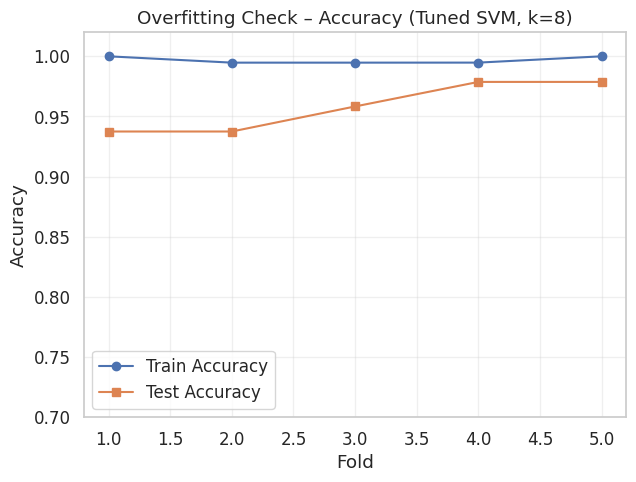

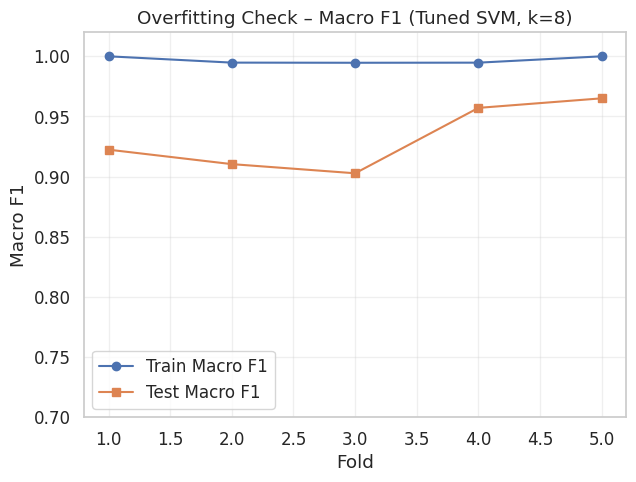

In [ ]:
fold_ids = np.arange(1, 6)

# -------- Accuracy Plot (SVM) --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(fold_ids, accuracies, marker='s', label="Test Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Overfitting Check – Accuracy (Tuned SVM, k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 1.02)
plt.legend()
plt.show()

# -------- Macro F1 Plot (SVM) --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_macro_f1s, marker='o', label="Train Macro F1")
plt.plot(fold_ids, macro_f1s, marker='s', label="Test Macro F1")
plt.xlabel("Fold")
plt.ylabel("Macro F1")
plt.title("Overfitting Check – Macro F1 (Tuned SVM, k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 1.02)
plt.legend()
plt.show()



=== Confusion Matrix – Fold 1 ===


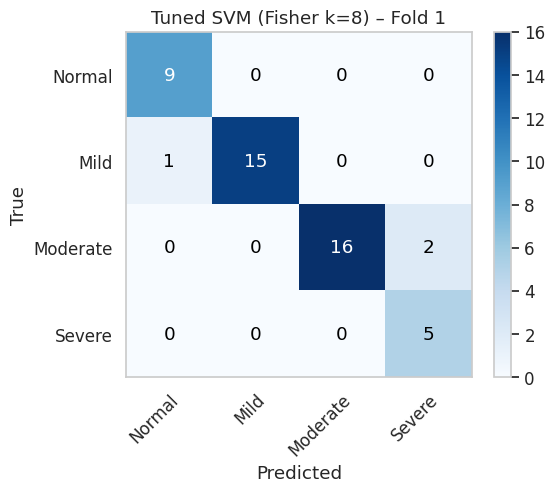


=== Confusion Matrix – Fold 2 ===


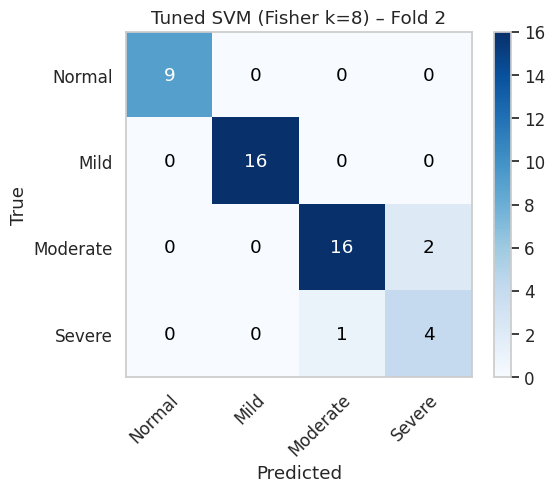


=== Confusion Matrix – Fold 3 ===


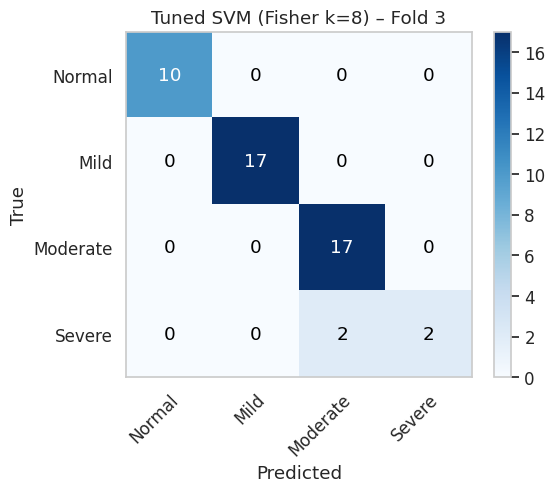


=== Confusion Matrix – Fold 4 ===


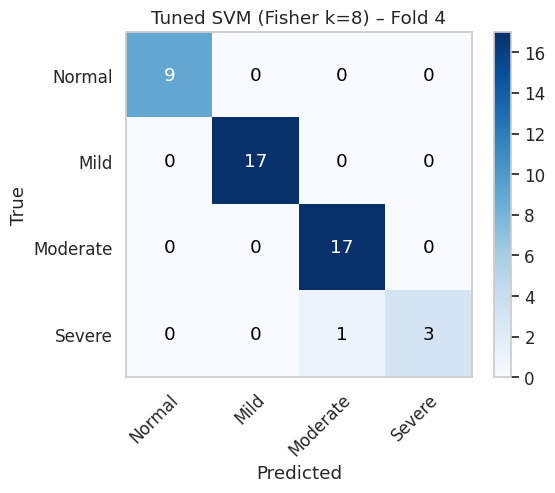


=== Confusion Matrix – Fold 5 ===


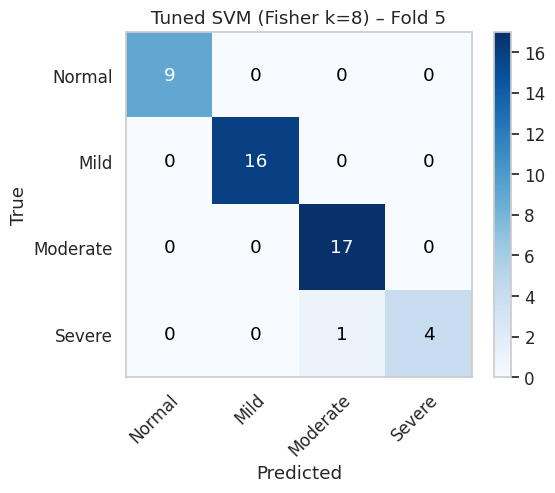

In [ ]:
# Plot confusion matrices for each fold of the tuned SVM (Fisher k=8)
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for fold, cm in cm_per_fold.items():
    print(f"\n=== Confusion Matrix – Fold {fold} ===")
    plot_confusion_matrix(
        cm,
        class_names,
        title=f"Tuned SVM (Fisher k=8) – Fold {fold}"
    )



=== Aggregated Confusion Matrix over 5 folds (SVM RBF) ===
[[46  0  0  0]
 [ 1 81  0  0]
 [ 0  0 83  4]
 [ 0  0  5 18]]


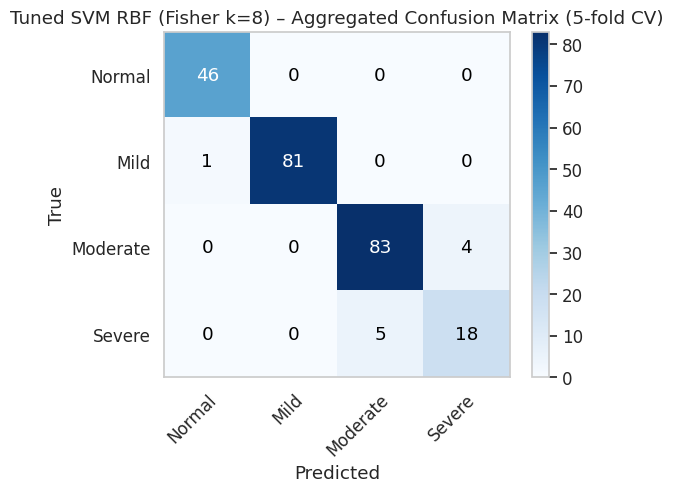

In [ ]:
def get_aggregated_confusion_matrix(cm_dict):
    """
    cm_dict: dictionary {fold_id: confusion_matrix}
    returns the sum of all fold confusion matrices (overall CM)
    """
    cms = list(cm_dict.values())      # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)         # element-wise sum
    return agg

cm_overall = get_aggregated_confusion_matrix(cm_per_fold)

print("\n=== Aggregated Confusion Matrix over 5 folds (SVM RBF) ===")
print(cm_overall)

plot_confusion_matrix(
    cm_overall,
    class_names,
    title="Tuned SVM RBF (Fisher k=8) – Aggregated Confusion Matrix (5-fold CV)"
)


# Refit the final model

In [ ]:
# Prepare full dataset (frequency-encode nominal columns) for training the final SVM model
X_all = X_final.copy()

for col in freq_cols_final:
    freq = X_all[col].value_counts(normalize=True)
    X_all[col] = X_all[col].map(freq).fillna(0)

print("X_all shape:", X_all.shape)

# Train the final SVM RBF model using the best hyperparameters on 100% of the cleaned data
final_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=best_C,          # best C from GridSearch
        gamma=best_gamma,  # best gamma from GridSearch
        class_weight="balanced",
        probability=True
    ))
])

final_svm.fit(X_all, y)

print("Final SVM RBF model trained on ALL data.")

X_all shape: (238, 8)
Final SVM RBF model trained on ALL data.


# Per-Class Metrics (averaged across folds)

In [ ]:
# cm_overall: aggregated confusion matrix over the 5 folds
# class_names: ["Normal", "Mild", "Moderate", "Severe"]

cm = cm_overall.copy()
class_names = ["Normal", "Mild", "Moderate", "Severe"]

per_class_acc = []
per_class_f1  = []

print("===== Per-Class Metrics (averaged across folds) =====\n")

for i, name in enumerate(class_names):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp

    # "Accuracy per class" = Recall = TP / (TP + FN)
    recall_i = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Precision = TP / (TP + FP)
    precision_i = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # F1-score
    if precision_i + recall_i > 0:
        f1_i = 2 * precision_i * recall_i / (precision_i + recall_i)
    else:
        f1_i = 0.0

    per_class_acc.append(recall_i)
    per_class_f1.append(f1_i)

    print(f"Class: {name}")
    print(f"  Accuracy: {recall_i:.4f}")
    print(f"  F1-score: {f1_i:.4f}\n")

# Averages across classes (macro)
avg_acc = np.mean(per_class_acc)
avg_f1  = np.mean(per_class_f1)

print("===== Averages Across Classes =====")
print(f"Average per-class Accuracy: {avg_acc}")
print(f"Average per-class F1: {avg_f1}")


===== Per-Class Metrics (averaged across folds) =====

Class: Normal
  Accuracy: 1.0000
  F1-score: 0.9892

Class: Mild
  Accuracy: 0.9878
  F1-score: 0.9939

Class: Moderate
  Accuracy: 0.9540
  F1-score: 0.9486

Class: Severe
  Accuracy: 0.7826
  F1-score: 0.8000

===== Averages Across Classes =====
Average per-class Accuracy: 0.9311091405516754
Average per-class F1: 0.9329209427685581


# **---------------------------------- Plots --------------------------------------**

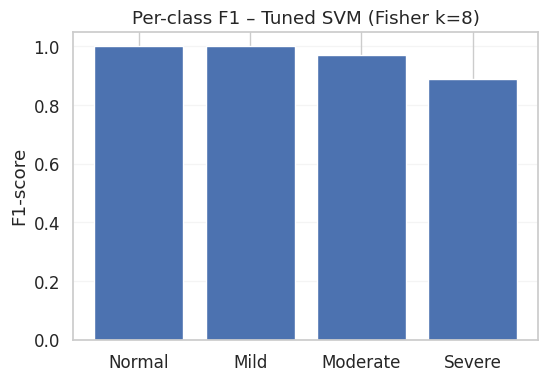

In [ ]:
# Plot per-class F1 scores for the tuned SVM (Fisher k=8)
report = classification_report(y_test, y_pred, target_names=["Normal","Mild","Moderate","Severe"], output_dict=True)
f1_per_class = [report[c]["f1-score"] for c in ["Normal","Mild","Moderate","Severe"]]

plt.figure(figsize=(6,4))
plt.bar(["Normal","Mild","Moderate","Severe"], f1_per_class)
plt.ylabel("F1-score")
plt.title("Per-class F1 – Tuned SVM (Fisher k=8)")
plt.ylim(0,1.05)
plt.grid(axis="y", alpha=0.2)
plt.show()

# precision recall curve

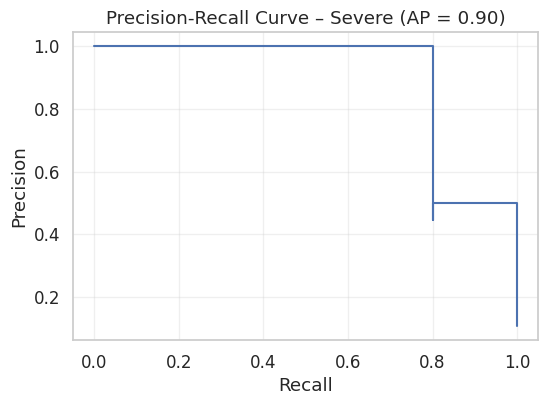

In [ ]:
# Plot the Precision–Recall curve for the Severe class (one-vs-rest)
# Convert true labels to binary (Severe = 1, others = 0)
y_true_severe = (y_test == severe_label).astype(int)
severe_probs = y_proba[:, severe_index]   # predicted probabilities for Severe class

# Compute precision–recall curve and Average Precision (AP)
precision, recall, _ = precision_recall_curve(y_true_severe, severe_probs)
ap = average_precision_score(y_true_severe, severe_probs)

plt.figure(figsize=(6,4))
plt.step(recall, precision, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve – Severe (AP = {ap:.2f})")
plt.grid(True, alpha=0.3)
plt.show()


# PCA

Note:
The SVM model operates in a high-dimensional feature space after scaling and non-linear mapping via the RBF kernel.
This PCA visualization compresses all features into only two principal components, so it shows only an approximate projection, not the true SVM decision boundaries.

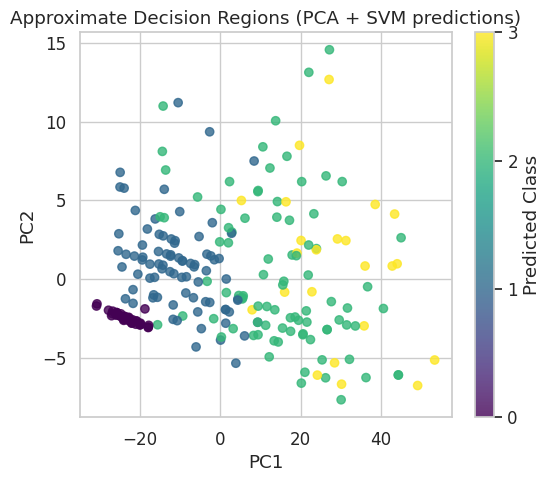

In [ ]:
# Visualize SVM predictions in 2D using PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

y_pred_all = final_svm.predict(X_all)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred_all, cmap='viridis', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Approximate Decision Regions (PCA + SVM predictions)")
plt.colorbar(scatter, ticks=[0,1,2,3], label="Predicted Class")
plt.show()


# **ROC**


===== Fold 1 =====
Train Acc: 1.000, Test Acc: 0.938, Train F1: 1.000, Test F1: 0.922, Train MCC: 1.000, Test MCC: 0.916, AP_severe: 0.853

===== Fold 2 =====
Train Acc: 0.995, Test Acc: 0.938, Train F1: 0.995, Test F1: 0.910, Train MCC: 0.993, Test MCC: 0.912, AP_severe: 0.833

===== Fold 3 =====
Train Acc: 0.995, Test Acc: 0.958, Train F1: 0.995, Test F1: 0.903, Train MCC: 0.993, Test MCC: 0.942, AP_severe: 0.560

===== Fold 4 =====
Train Acc: 0.995, Test Acc: 0.979, Train F1: 0.995, Test F1: 0.957, Train MCC: 0.993, Test MCC: 0.970, AP_severe: 0.917

===== Fold 5 =====
Train Acc: 1.000, Test Acc: 0.979, Train F1: 1.000, Test F1: 0.965, Train MCC: 1.000, Test MCC: 0.970, AP_severe: 0.900

===== FINAL 5-fold CV (Tuned SVM, Fisher k=8) =====
Mean Train Acc: 0.9968476164232571
Mean Test  Acc: 0.9581560283687944
Mean Train F1: 0.9968248619720548
Mean Test  F1: 0.9315589301008256
Mean MCC: 0.9419921674585936
Mean AP Severe: 0.8125906593406593


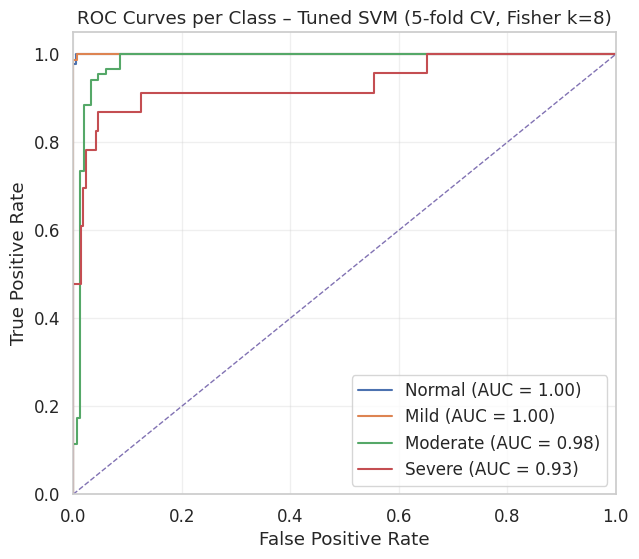

In [ ]:
# ============================
# 5-fold Stratified CV for Tuned SVM (Fisher k=8)
# ============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists for TEST metrics
accuracies        = []
macro_f1s         = []
macro_precisions  = []
macro_recalls     = []
mccs              = []
ap_severe_ls      = []

# Lists for TRAIN metrics
train_accuracies    = []
train_macro_f1s     = []
train_macro_precs   = []
train_macro_recalls = []
train_mccs          = []

# Confusion matrices per fold
cm_per_fold = {}

# For ROC (out-of-fold predictions)
all_y_test  = []   # true labels from all folds
all_y_proba = []   # predicted probabilities from all folds

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):

    print(f"\n===== Fold {fold} =====")

    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # -------- Frequency Encoding (TRAIN ONLY) --------
    for col in freq_cols_final:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col]  = X_test[col].map(freq).fillna(0)

    # -------- Tuned SVM RBF Model --------
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("svm", SVC(
            kernel='rbf',
            C=best_C,
            gamma=best_gamma,
            class_weight='balanced',
            probability=True
        ))
    ])

    # ===== TRAIN =====
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_train_pred)
    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_macro_p  = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_macro_r  = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_mcc      = matthews_corrcoef(y_train, y_train_pred)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_macro_precs.append(train_macro_p)
    train_macro_recalls.append(train_macro_r)
    train_mccs.append(train_mcc)

    # ===== TEST =====
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc           = accuracy_score(y_test, y_pred)
    macro_f1      = f1_score(y_test, y_pred, average='macro')
    macro_prec    = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_rec     = recall_score(y_test, y_pred, average='macro', zero_division=0)
    mcc           = matthews_corrcoef(y_test, y_pred)

    # AP for Severe class
    y_test_severe = (y_test == severe_label).astype(int)
    svm_step      = model.named_steps["svm"]
    severe_index  = np.where(svm_step.classes_ == severe_label)[0][0]
    severe_probs  = y_proba[:, severe_index]
    ap_severe     = average_precision_score(y_test_severe, severe_probs)

    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    macro_precisions.append(macro_prec)
    macro_recalls.append(macro_rec)
    mccs.append(mcc)
    ap_severe_ls.append(ap_severe)

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))
    cm_per_fold[fold] = cm

    # Save out-of-fold predictions for ROC
    all_y_test.append(y_test.values)
    all_y_proba.append(y_proba)

    print(
        f"Train Acc: {train_acc:.3f}, Test Acc: {acc:.3f}, "
        f"Train F1: {train_macro_f1:.3f}, Test F1: {macro_f1:.3f}, "
        f"Train MCC: {train_mcc:.3f}, Test MCC: {mcc:.3f}, "
        f"AP_severe: {ap_severe:.3f}"
    )

# ============================
# Final CV Results
# ============================

print("\n===== FINAL 5-fold CV (Tuned SVM, Fisher k=8) =====")
print("Mean Train Acc:", np.mean(train_accuracies))
print("Mean Test  Acc:", np.mean(accuracies))
print("Mean Train F1:", np.mean(train_macro_f1s))
print("Mean Test  F1:", np.mean(macro_f1s))
print("Mean MCC:", np.mean(mccs))
print("Mean AP Severe:", np.mean(ap_severe_ls))

# ============================
# ROC per class using out-of-fold predictions
# ============================

# Concatenate all folds
y_oof     = np.concatenate(all_y_test, axis=0)
proba_oof = np.vstack(all_y_proba)

class_ids   = [0, 1, 2, 3]
class_names = ["Normal", "Mild", "Moderate", "Severe"]

# One-vs-rest binarization
y_oof_bin = label_binarize(y_oof, classes=class_ids)

fpr = {}
tpr = {}
roc_auc = {}

for i, cid in enumerate(class_ids):
    fpr[cid], tpr[cid], _ = roc_curve(y_oof_bin[:, i], proba_oof[:, i])
    roc_auc[cid] = auc(fpr[cid], tpr[cid])

plt.figure(figsize=(7, 6))
for i, cid in enumerate(class_ids):
    plt.plot(
        fpr[cid], tpr[cid],
        label=f"{class_names[i]} (AUC = {roc_auc[cid]:.2f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class – Tuned SVM (5-fold CV, Fisher k=8)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


# Re-fit Final Model - SANDS SVM-RBF Class


In [ ]:
# Refit the final model

# Prepare full dataset (frequency-encode nominal columns) for training the final SVM model
X_all = X_final.copy()

for col in freq_cols_final:
    freq = X_all[col].value_counts(normalize=True)
    X_all[col] = X_all[col].map(freq).fillna(0)

print("X_all shape:", X_all.shape)


X_all shape: (238, 8)


In [ ]:
feature_order = list(X_all.columns)

freq_maps_final = {}
for col in freq_cols_final:
    freq = X_all[col].value_counts(normalize=True)
    freq_maps_final[col] = freq.to_dict()

print("Feature order:", feature_order)
print("Frequency maps for categorical features:")
for col, mapping in freq_maps_final.items():
    print(f"- {col}: {mapping}")

final_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=best_C,          # best C from tuning
        gamma=best_gamma,  # best gamma from tuning
        class_weight="balanced",
        probability=True
    ))
])

final_svm.fit(X_all, y)

print("Final SVM RBF model trained on ALL data.")

Feature order: ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']
Frequency maps for categorical features:
- injury_type: {0.2815126050420168: 0.2815126050420168, 0.19327731092436976: 0.19327731092436976, 0.15546218487394958: 0.15546218487394958, 0.12605042016806722: 0.12605042016806722, 0.07983193277310924: 0.07983193277310924, 0.04201680672268908: 0.04201680672268908, 0.02100840336134454: 0.04201680672268908, 0.029411764705882353: 0.029411764705882353, 0.025210084033613446: 0.025210084033613446, 0.012605042016806723: 0.012605042016806723, 0.008403361344537815: 0.008403361344537815, 0.004201680672268907: 0.004201680672268907}
Final SVM RBF model trained on ALL data.


In [ ]:
import pandas as pd
import joblib

class SANDSModelSVM:
    """
    SANDSModelSVM
    --------------
    Wrapper around the FINAL SVM RBF model (final_svm) providing:
    - Neuromuscular ordinal encoding
    - Frequency encoding for categorical features (e.g., injury_type)
    - Real-time user input collection
    - Prediction with class probabilities
    """

    def __init__(self, svm_model, feature_order, freq_maps, label_map=None):
        # Trained Pipeline(SVM) + metadata
        self.model = svm_model
        self.feature_order = feature_order
        self.freq_maps = freq_maps    # dict: {col_name: {category: freq, ...}}

        # Numerical → Severity label mapping
        self.label_map = label_map or {
            0: "Normal",
            1: "Mild",
            2: "Moderate",
            3: "Severe"
        }

        # Ordinal encoding rules for neuromuscular features
        self.neurometric_encoding = {
            "Fasciculation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Positive_Sharp_Waves": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Fibrillation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            }
        }

    # USER INPUT ENCODING (Raw → Numerical → DataFrame)
    def encode_user_input(self, user_input):
        """
        Converts raw user inputs (strings/numbers) into a numerical
        DataFrame matching the trained model's feature order.
        """

        def encode_neuro(feature, value):
            """Apply ordinal encoding to neuromuscular fields."""
            if feature in self.neurometric_encoding:
                return self.neurometric_encoding[feature].get(value, 0)
            return value

        final = {
            # Neuromuscular ordinal fields
            "Fasciculation": encode_neuro("Fasciculation", user_input["Fasciculation"]),
            "Polyphasic_Units": int(user_input["Polyphasic_Units"]),
            "Positive_Sharp_Waves": encode_neuro("Positive_Sharp_Waves", user_input["Positive_Sharp_Waves"]),
            "Fibrillation": encode_neuro("Fibrillation", user_input["Fibrillation"]),

            # Numeric MUAP / time features
            "MUAP_Amplitude (mV)": float(user_input["MUAP_Amplitude (mV)"]),
            "MUAP_Duration (ms)": float(user_input["MUAP_Duration (ms)"]),
            "time_since_injury_months": float(user_input["time_since_injury_months"]),

            # Categorical feature(s) before frequency encoding
            "injury_type": user_input["injury_type"]
        }

        # Apply frequency encoding to categorical columns using stored maps
        for col, mapping in self.freq_maps.items():
            if col in final:
                raw_val = final[col]
                final[col] = mapping.get(raw_val, 0.0)  # unseen category → 0

        # Build single-row DataFrame with correct column order
        df = pd.DataFrame([final])
        df = df[self.feature_order]

        return df

    # REAL-TIME USER INPUT COLLECTION (Interactive)
    def realtime_user_input(self):
        """
        Interactive CLI-style questionnaire used to collect user inputs.
        """

        def ask_neuro(feature_name):
            """Prompt user to choose from neuromuscular ordinal options."""
            print(f"\n{feature_name} options:")
            print("  1) Absent")
            print("  2) Present (1+)")
            print("  3) Present (2+)")
            print("  4) Present (3+)")

            while True:
                c = input(f"Choose {feature_name} (1-4): ").strip()
                if c == "1": return "Absent"
                if c == "2": return "Present (1+)"
                if c == "3": return "Present (2+)"
                if c == "4": return "Present (3+)"
                print("Invalid input. Try again.")

        user = {}

        # Neuromuscular fields
        user["Fasciculation"]        = ask_neuro("Fasciculation")
        user["Positive_Sharp_Waves"] = ask_neuro("Positive_Sharp_Waves")
        user["Fibrillation"]         = ask_neuro("Fibrillation")

        # Numeric inputs
        user["Polyphasic_Units"]         = input("\nPolyphasic Units: ")
        user["MUAP_Amplitude (mV)"]      = input("MUAP Amplitude (mV): ")
        user["MUAP_Duration (ms)"]       = input("MUAP Duration (ms): ")
        user["time_since_injury_months"] = input("Time Since Injury (months): ")

        # Categorical input
        user["injury_type"] = input("\nInjury Type: ")

        return user

    # TOP-LEVEL PREDICTION FUNCTION (Raw Input → Output)
    def predict_from_user_input(self, raw_user_input):
        """
        Full pipeline: encode → predict.
        """
        encoded_df = self.encode_user_input(raw_user_input)
        return self.predict_with_probs(encoded_df)

    # MODEL PREDICTION + PROBABILITIES
    def predict_with_probs(self, sample_df):
        """
        Returns:
        - predicted severity label
        - confidence score
        - class probability distribution
        """

        preds = self.model.predict(sample_df)
        probas = self.model.predict_proba(sample_df)[0]  # needs probability=True in SVC
        classes = self.model.named_steps["svm"].classes_

        pred_int = int(preds[0])
        pred_label = self.label_map[pred_int]

        # Convert numerical probs → human-readable labels
        prob_dict = {
            self.label_map[c]: float(p)
            for c, p in zip(classes, probas)
        }

        confidence = float(max(probas))

        # Display prediction summary
        print("\n===== Prediction Result (SVM RBF) =====")
        print("Predicted Class:", pred_label)
        print(f"Confidence: {confidence*100:.2f}%")

        print("\nClass Probabilities:")
        for cls, p in prob_dict.items():
            print(f"  {cls}: {p*100:.2f}%")

        return pred_label, confidence, prob_dict


In [ ]:
11# Create SANDSModelSVM instance using the FINAL trained SVM model
sands_svm_model = SANDSModelSVM(
    svm_model=final_svm,
    feature_order=feature_order,
    freq_maps=freq_maps_final
)

# Save to disk
joblib.dump(sands_svm_model, "sands_svm.pkl")
print("Saved SVM SANDS model to sands_svm.pkl")

# ===========================
# Test Final Approved Model
# ===========================
loaded_sands_svm = joblib.load("sands_svm.pkl")

raw_user = loaded_sands_svm.realtime_user_input()
pred, conf, probs = loaded_sands_svm.predict_from_user_input(raw_user)


Saved SVM SANDS model to sands_svm.pkl

Fasciculation options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
